In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import Model
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, concatenate
from keras.metrics import binary_crossentropy, Mean
import keras.backend as K
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
from tensorflow.math import reduce_mean, reduce_sum

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

import os

In [2]:
path = r"C:\Users\User\Desktop\Homework\S5\PRO1\A_Z Handwritten Data.csv"
data = pd.read_csv(path).astype('float32')
x = data.drop('0', axis=1)
y = data['0']
x /= 255

In [3]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28,28,1))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28,28,1))
train_x = np.concatenate((train_x, test_x), axis = 0)
train_y = np.concatenate((train_y, test_y), axis = 0)

labels_len = len(np.unique(train_y))

train_y = to_categorical(train_y)

In [4]:
dictionary = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}

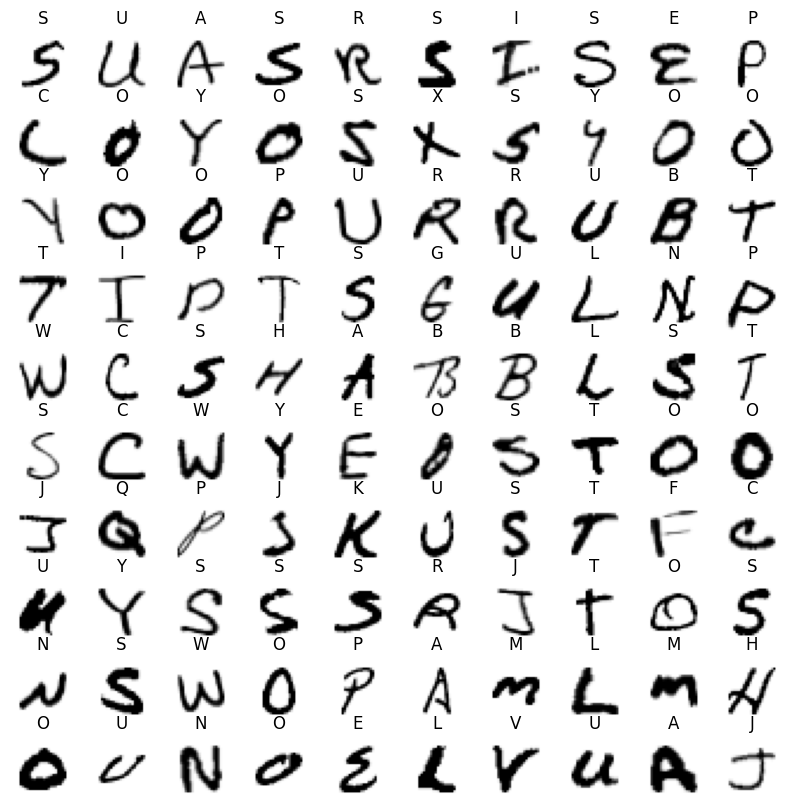

In [5]:
plt.figure(figsize=(10, 10))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(train_x[i], cmap="Greys")
    plt.title(dictionary.get(np.argmax(train_y[i])))
    plt.axis("off")
plt.show()

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
image_size = test_x.shape[1]

In [8]:
input_shape = (image_size, image_size, 1)
label_shape = (labels_len, )
kernel_size = 3
filters = [32, 64]
latent_dim = 2
inside_dim = 16
epochs = 30
batch_size = 128
betha = 1.0

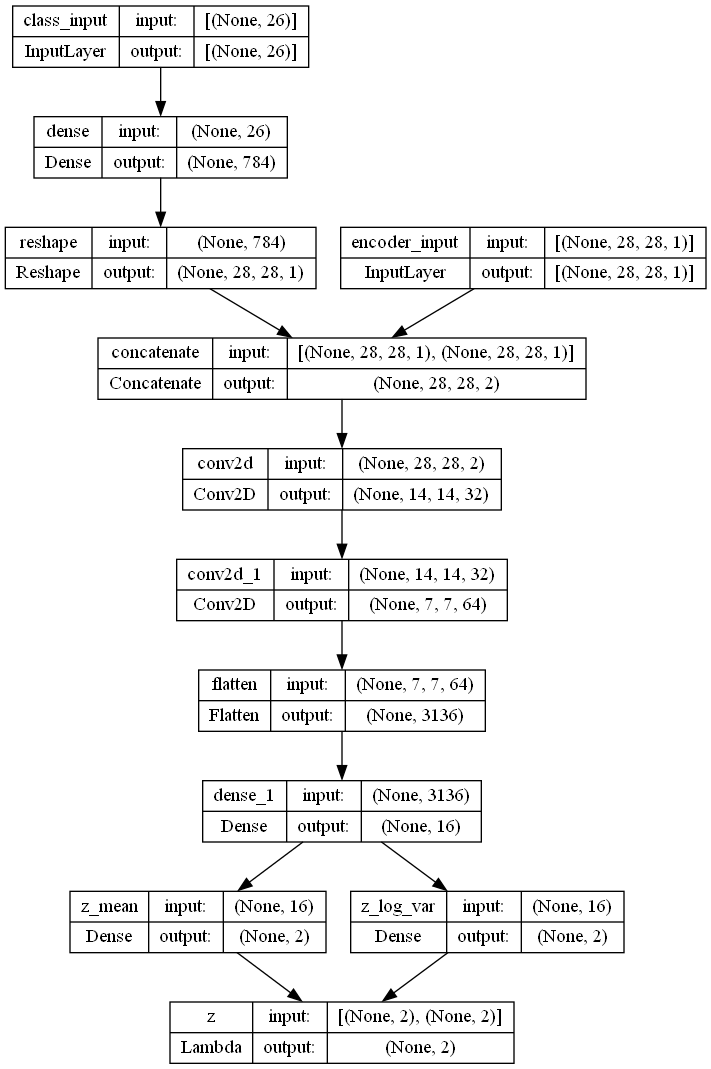

In [9]:
inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_input')
x = Dense(image_size * image_size)(y_labels)
x = Reshape((image_size, image_size, 1))(x)
x = concatenate([x, inputs])

for f in filters:
    x = Conv2D(filters=f,
                kernel_size=kernel_size,
                strides=2,
                activation='relu',
                padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(inside_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model([inputs, y_labels],
                [z_mean, z_log_var, z],
                name='encoder')
plot_model(encoder, show_shapes=True)

In [10]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 class_input (InputLayer)       [(None, 26)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 784)          21168       ['class_input[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['dense[0][0]']                  
                                                                                                  
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                            

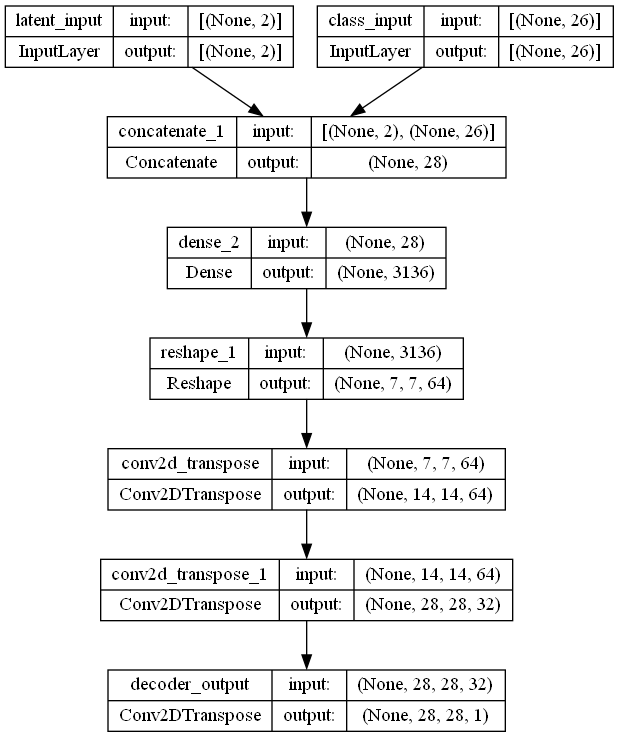

In [11]:
latent_inputs = Input(shape=(latent_dim, ), name='latent_input')

x = concatenate([latent_inputs, y_labels])
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for f in filters[::-1]:
    x = Conv2DTranspose(filters=f,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    
outputs = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            name='decoder_output')(x)

decoder = Model([latent_inputs, y_labels], outputs, name='decoder')
plot_model(decoder, show_shapes=True)

In [12]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_input (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 class_input (InputLayer)       [(None, 26)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 28)           0           ['latent_input[0][0]',           
                                                                  'class_input[0][0]']            
                                                                                                  
 dense_2 (Dense)                (None, 3136)         90944       ['concatenate_1[0][0]']    

In [13]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker =Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            inputs, y_labels = data
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder([z, y_labels])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    binary_crossentropy(inputs, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)) * betha
            kl_loss = reduce_mean(reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [14]:
save_dir = "wagi_letter_cvae_cnn"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, 'cvae_cnn_letters.tf')

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
vae.load_weights(filepath)

In [16]:
vae.fit(train_x, train_y, epochs=epochs, batch_size=batch_size)

Epoch 1/30
2910/2910 [==============================] - 164s 56ms/step - loss: 184.7992 - reconstruction_loss: 155.2759 - kl_loss: 4.2477
Epoch 2/30
2910/2910 [==============================] - 180s 62ms/step - loss: 147.8546 - reconstruction_loss: 142.4783 - kl_loss: 4.8721
Epoch 3/30
2910/2910 [==============================] - 179s 62ms/step - loss: 145.9577 - reconstruction_loss: 140.7249 - kl_loss: 4.9784
Epoch 4/30
2910/2910 [==============================] - 166s 57ms/step - loss: 144.8442 - reconstruction_loss: 139.6174 - kl_loss: 5.0678
Epoch 5/30
2910/2910 [==============================] - 164s 56ms/step - loss: 143.9748 - reconstruction_loss: 138.8126 - kl_loss: 5.1437
Epoch 6/30
2910/2910 [==============================] - 163s 56ms/step - loss: 143.4807 - reconstruction_loss: 138.1914 - kl_loss: 5.2026
Epoch 7/30
2910/2910 [==============================] - 162s 55ms/step - loss: 143.0766 - reconstruction_loss: 137.6926 - kl_loss: 5.2511
Epoch 8/30
2910/2910 [============

In [57]:
vae.save_weights(filepath)

1/1 [==============================] - 0s 17ms/step


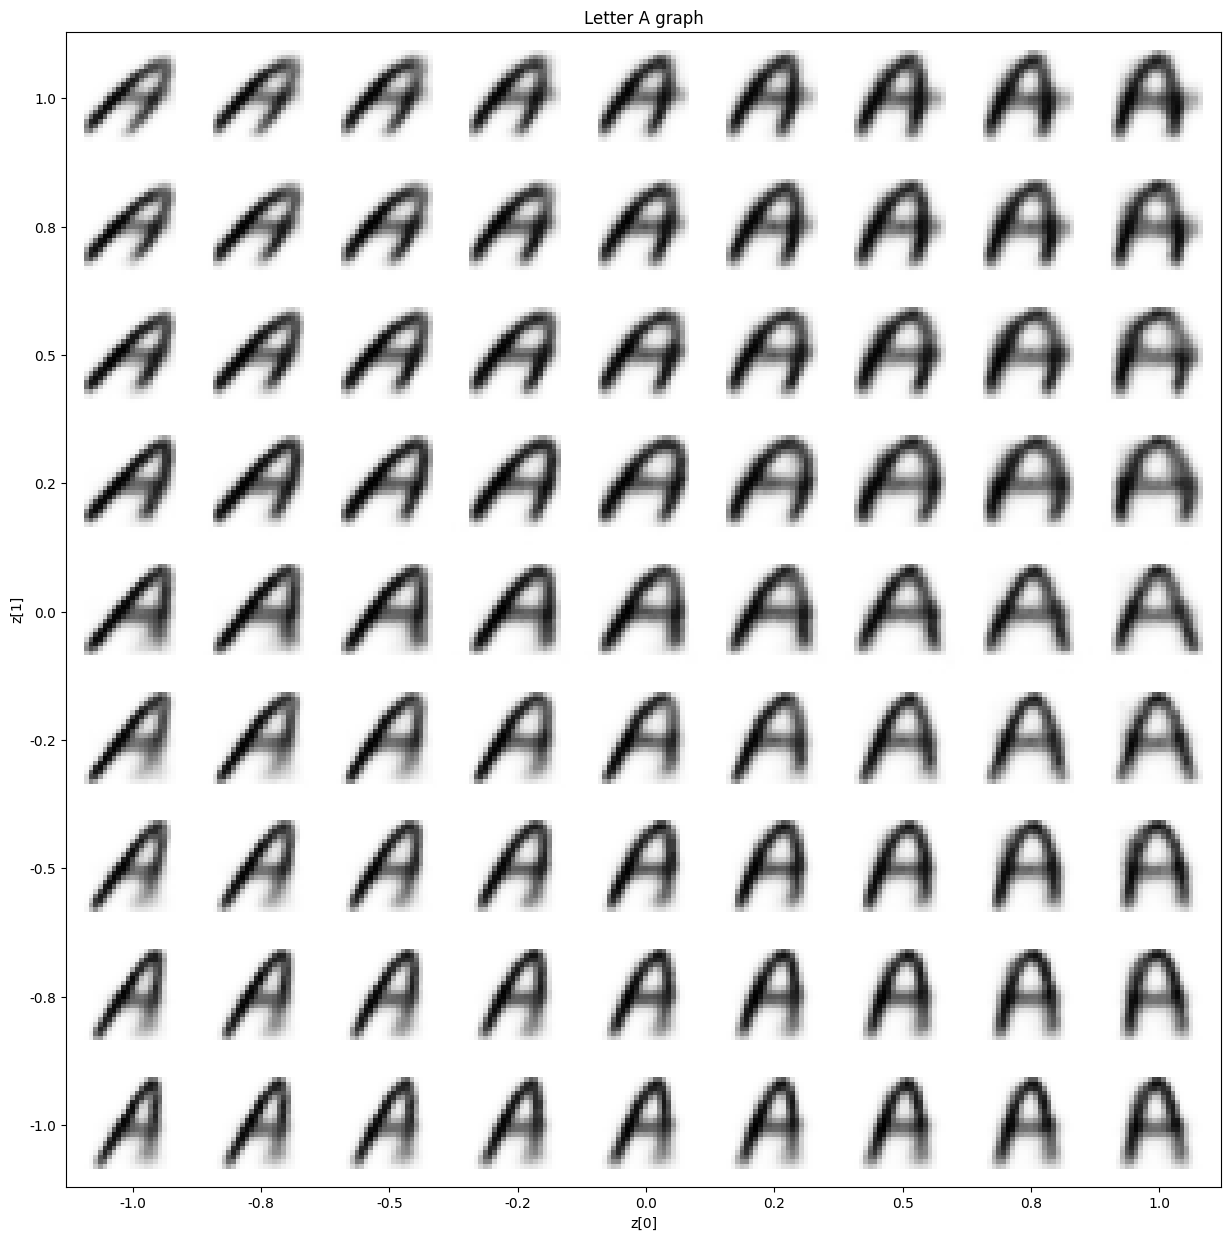

1/1 [==============================] - 0s 25ms/step


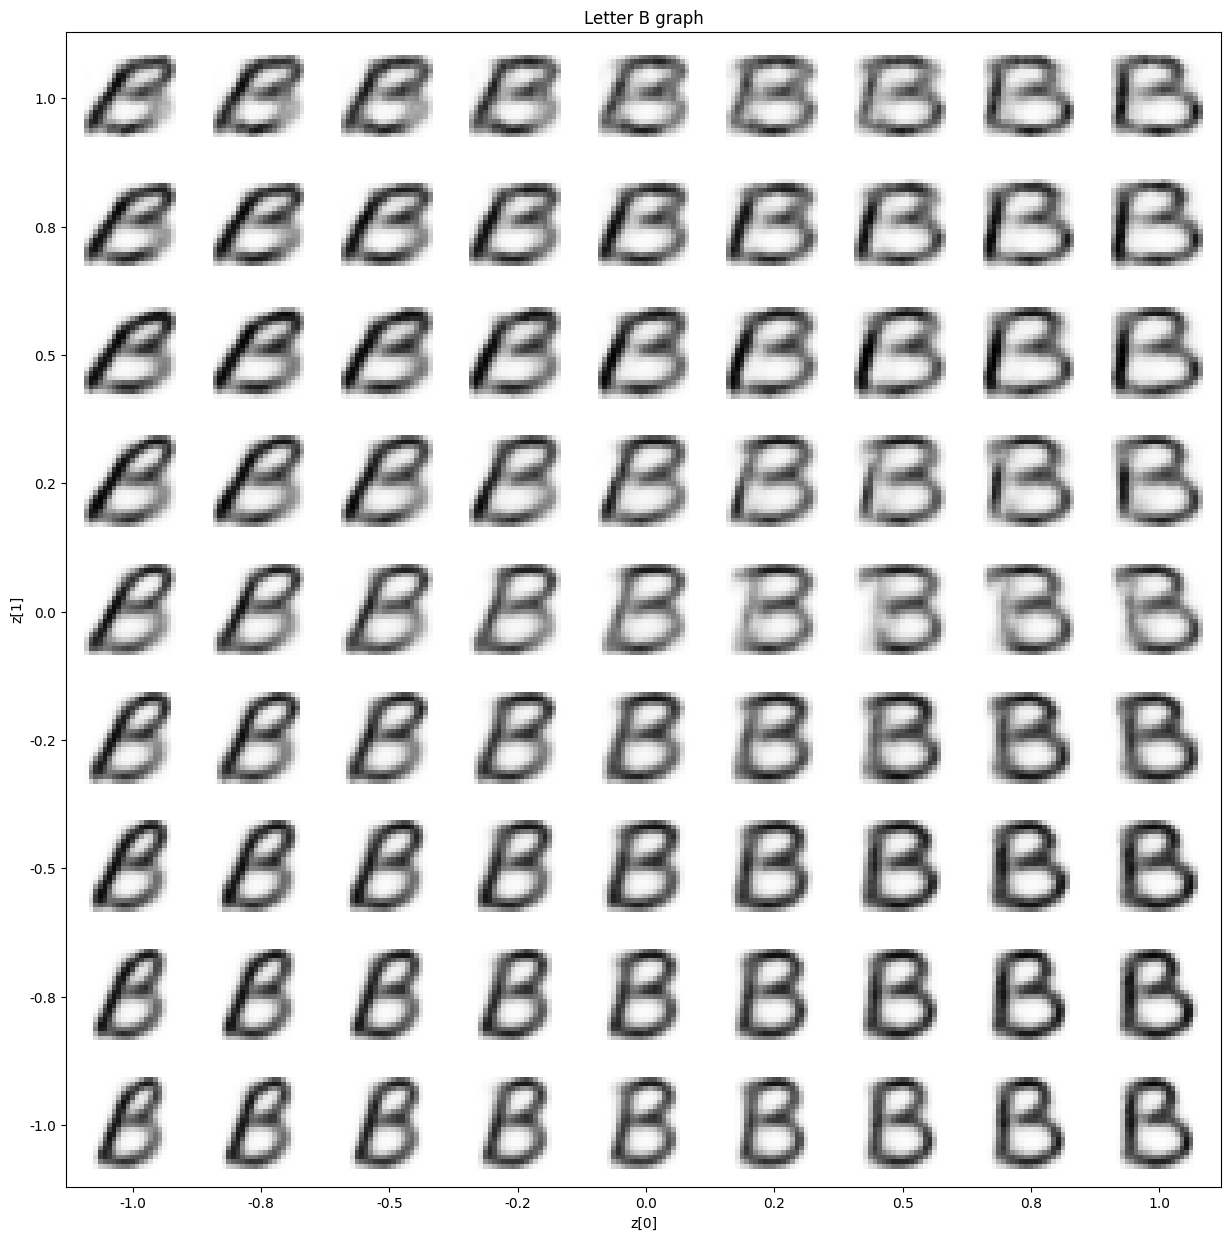

1/1 [==============================] - 0s 16ms/step


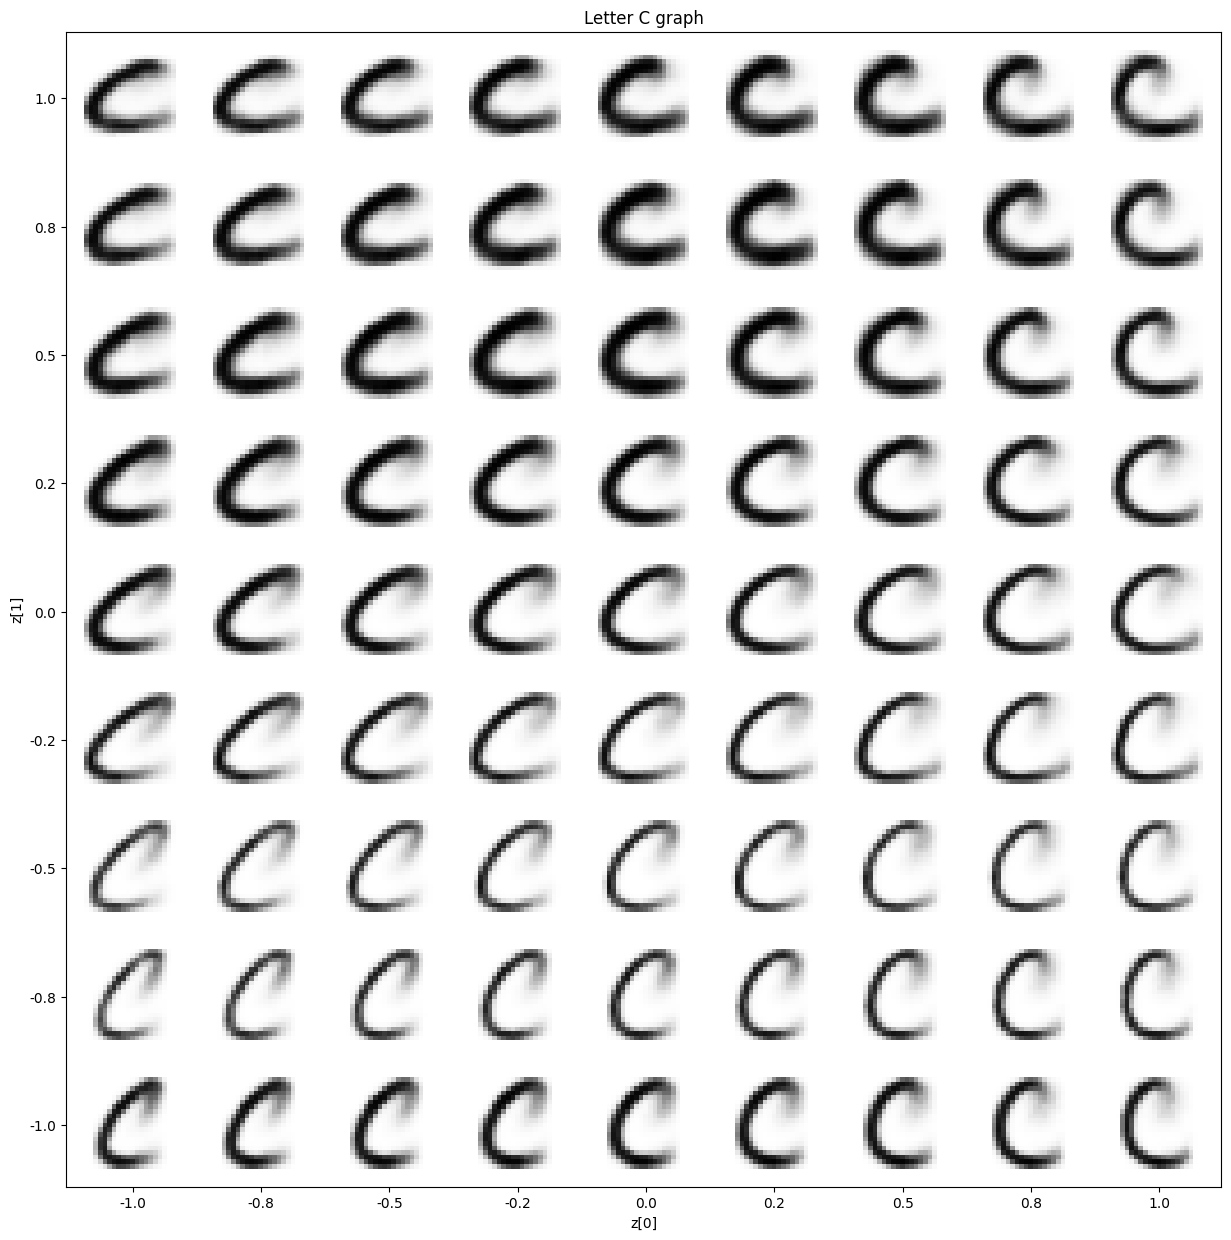

1/1 [==============================] - 0s 16ms/step


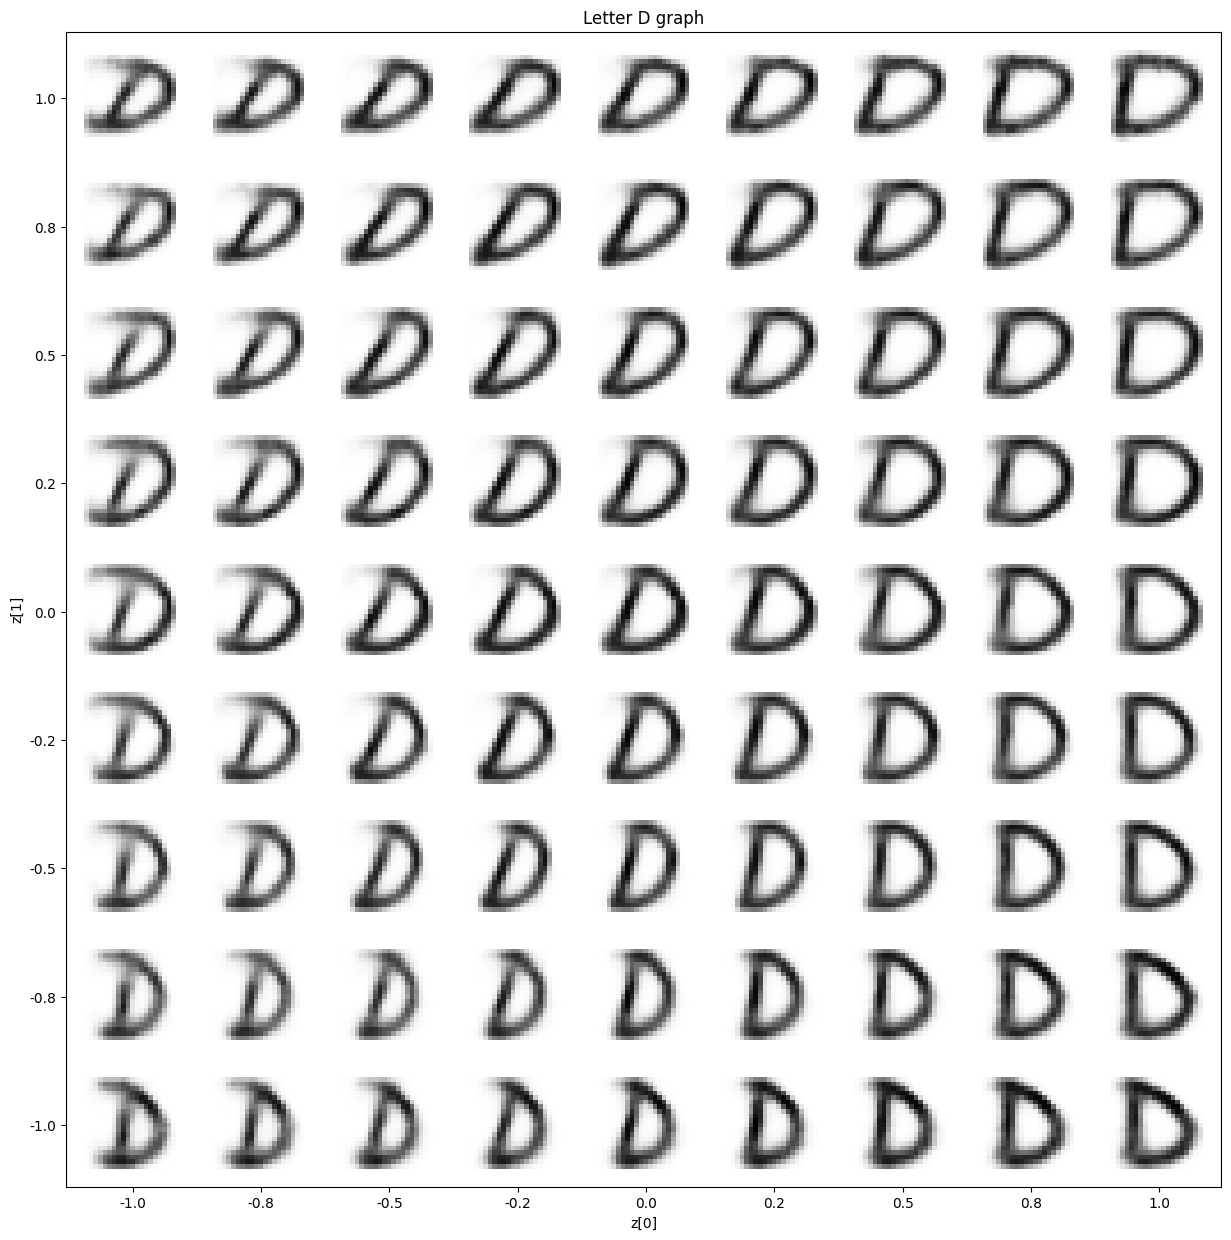

1/1 [==============================] - 0s 18ms/step


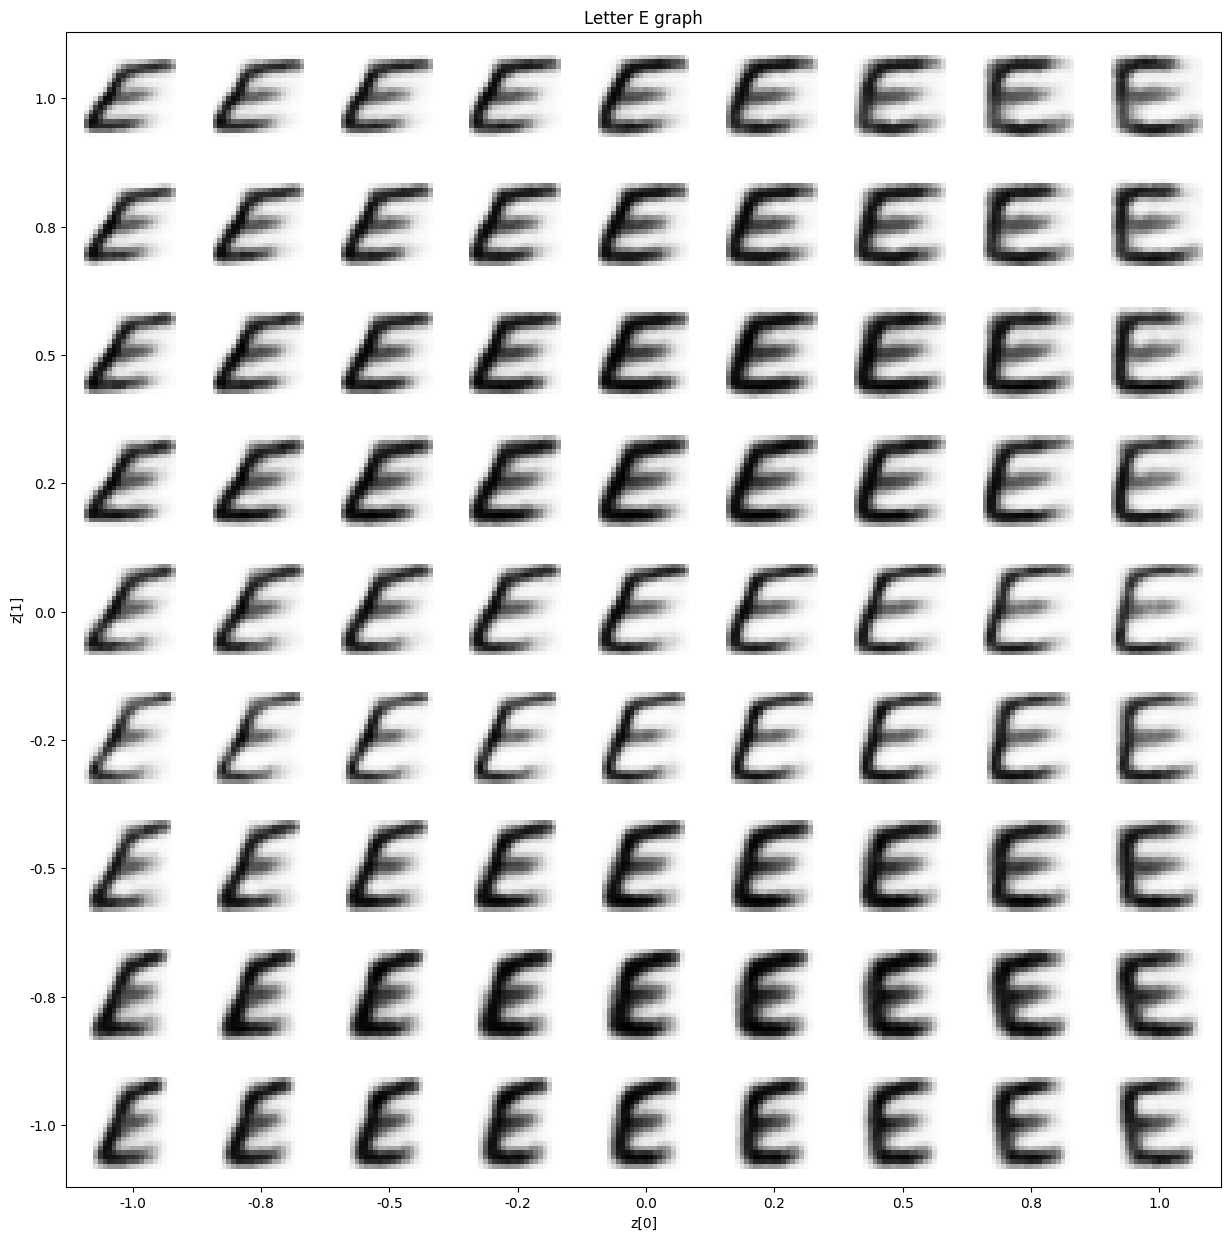

1/1 [==============================] - 0s 26ms/step


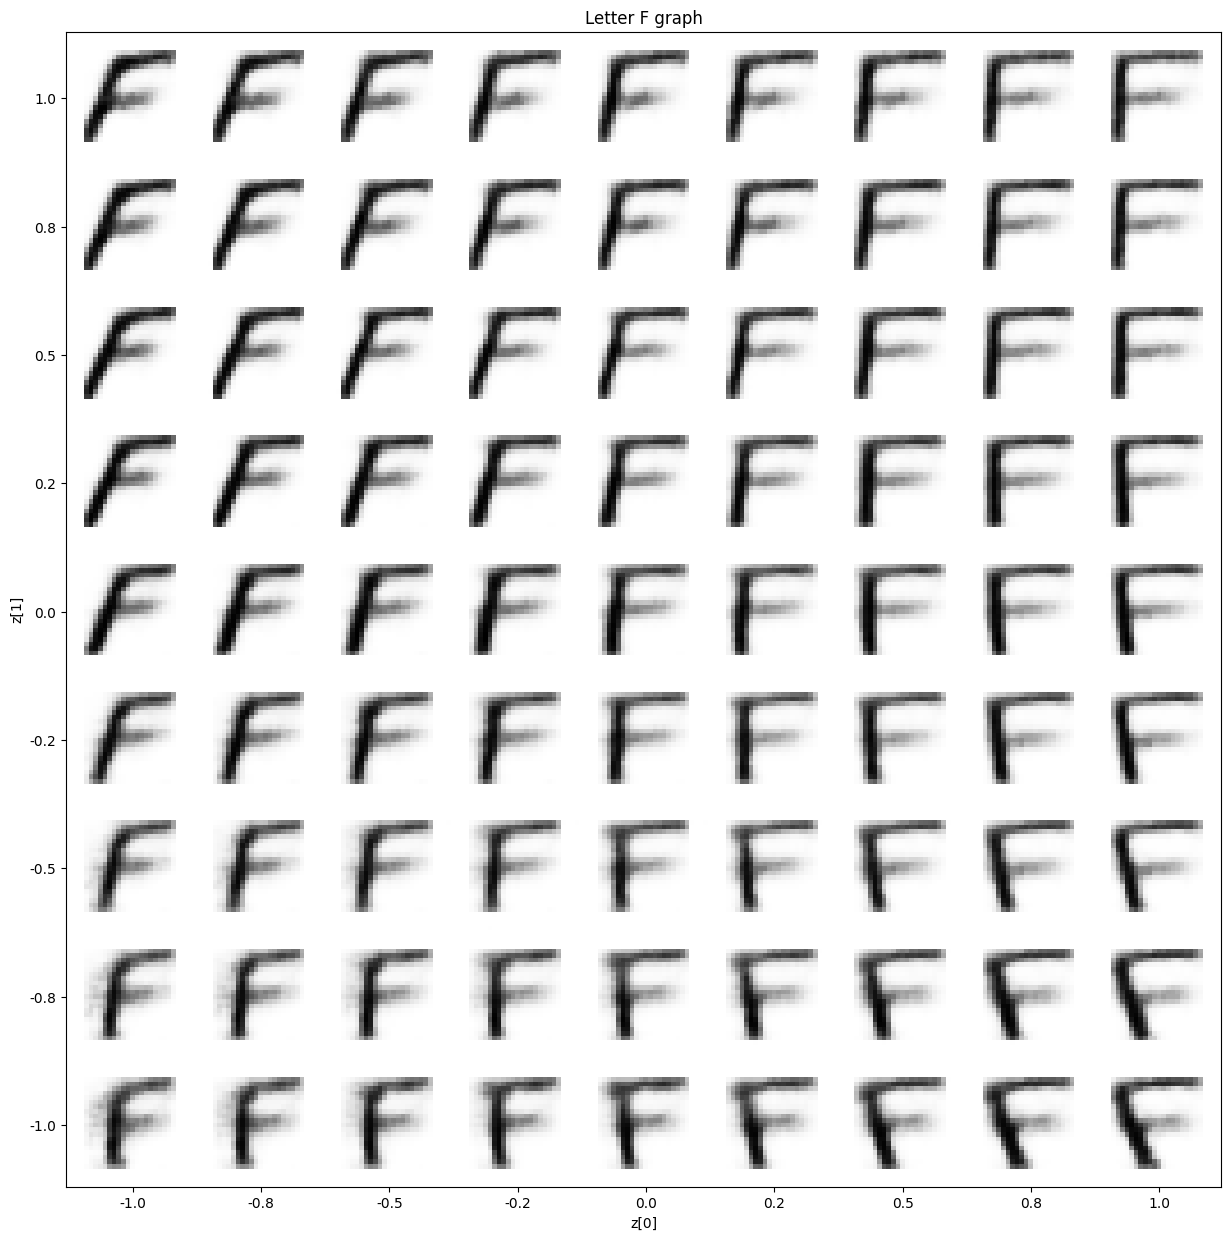

1/1 [==============================] - 0s 17ms/step


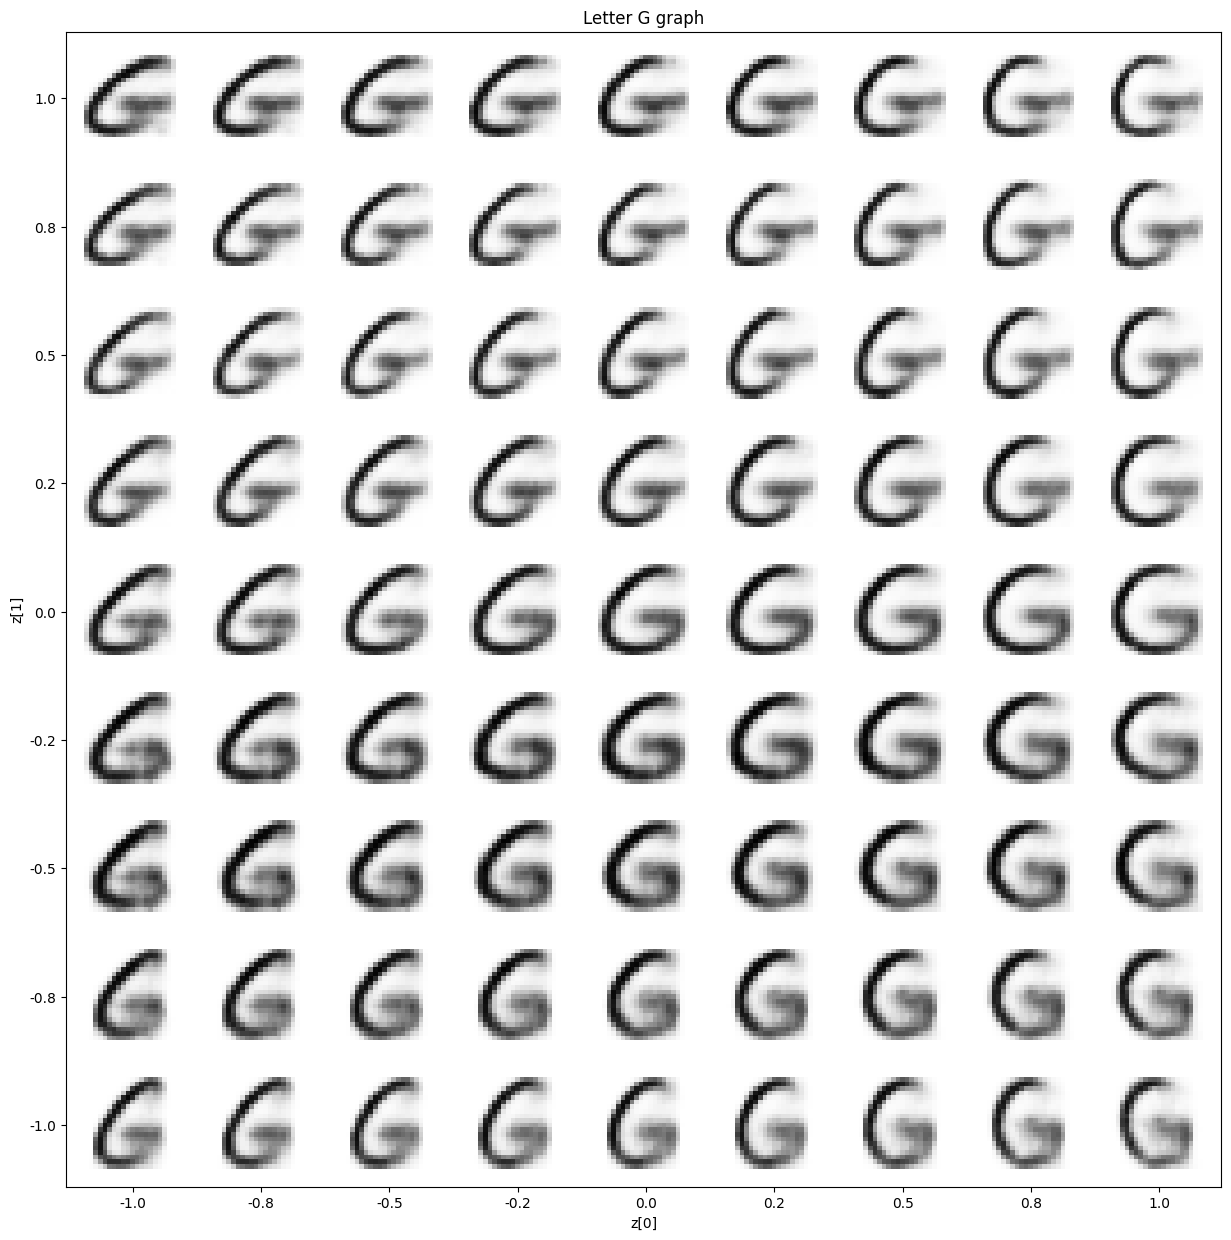

1/1 [==============================] - 0s 16ms/step


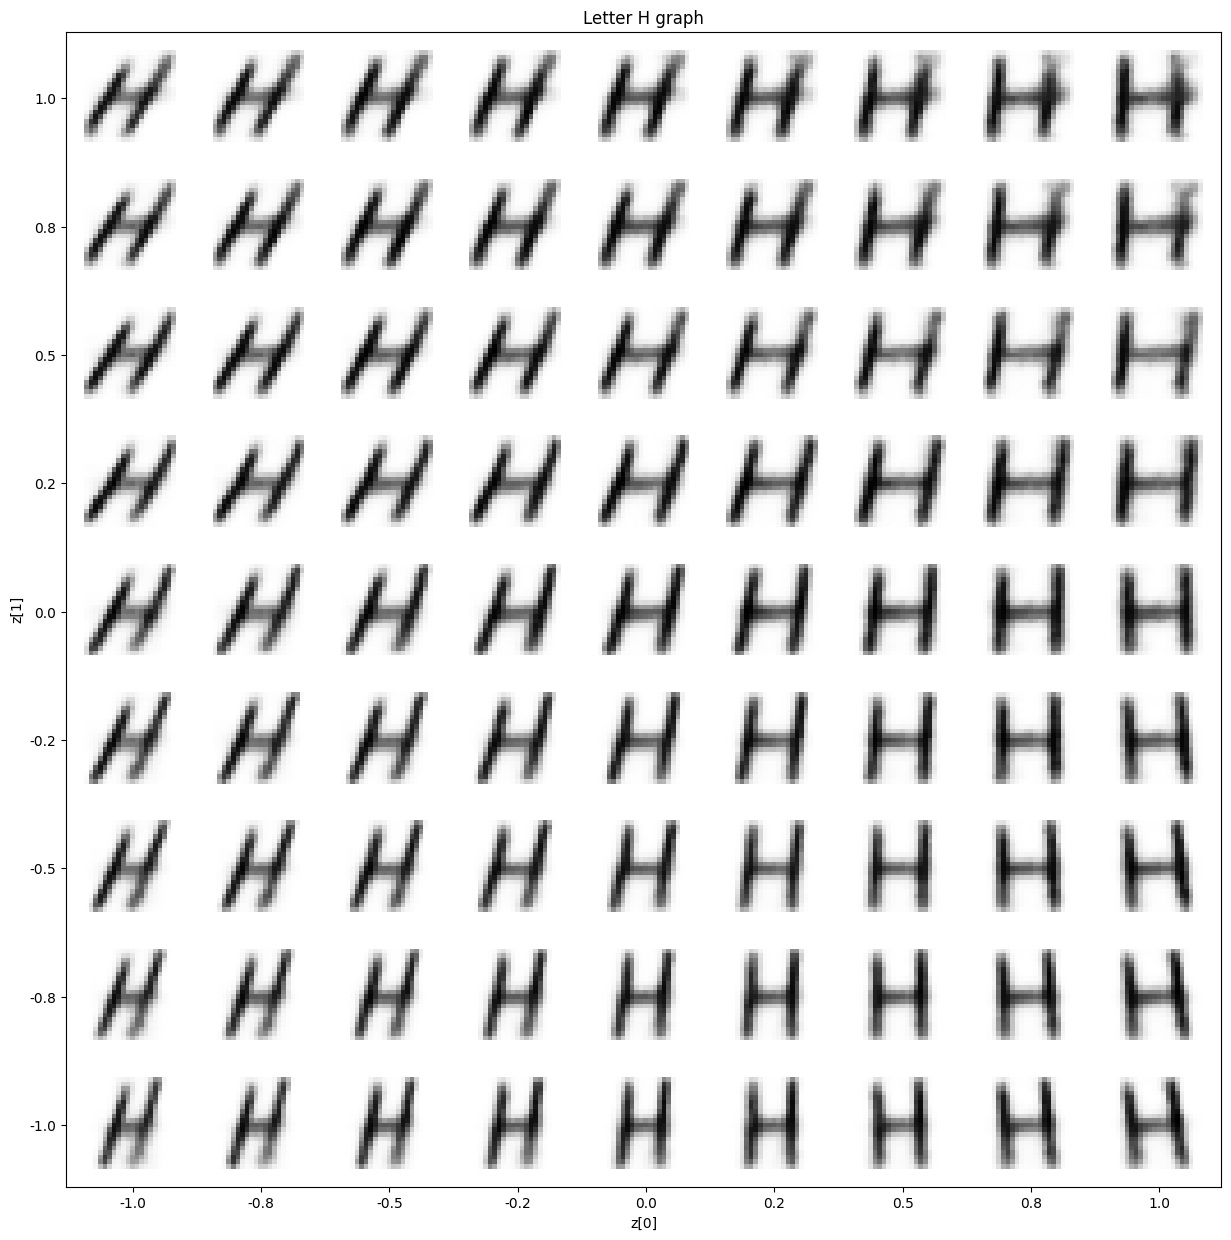

1/1 [==============================] - 0s 16ms/step


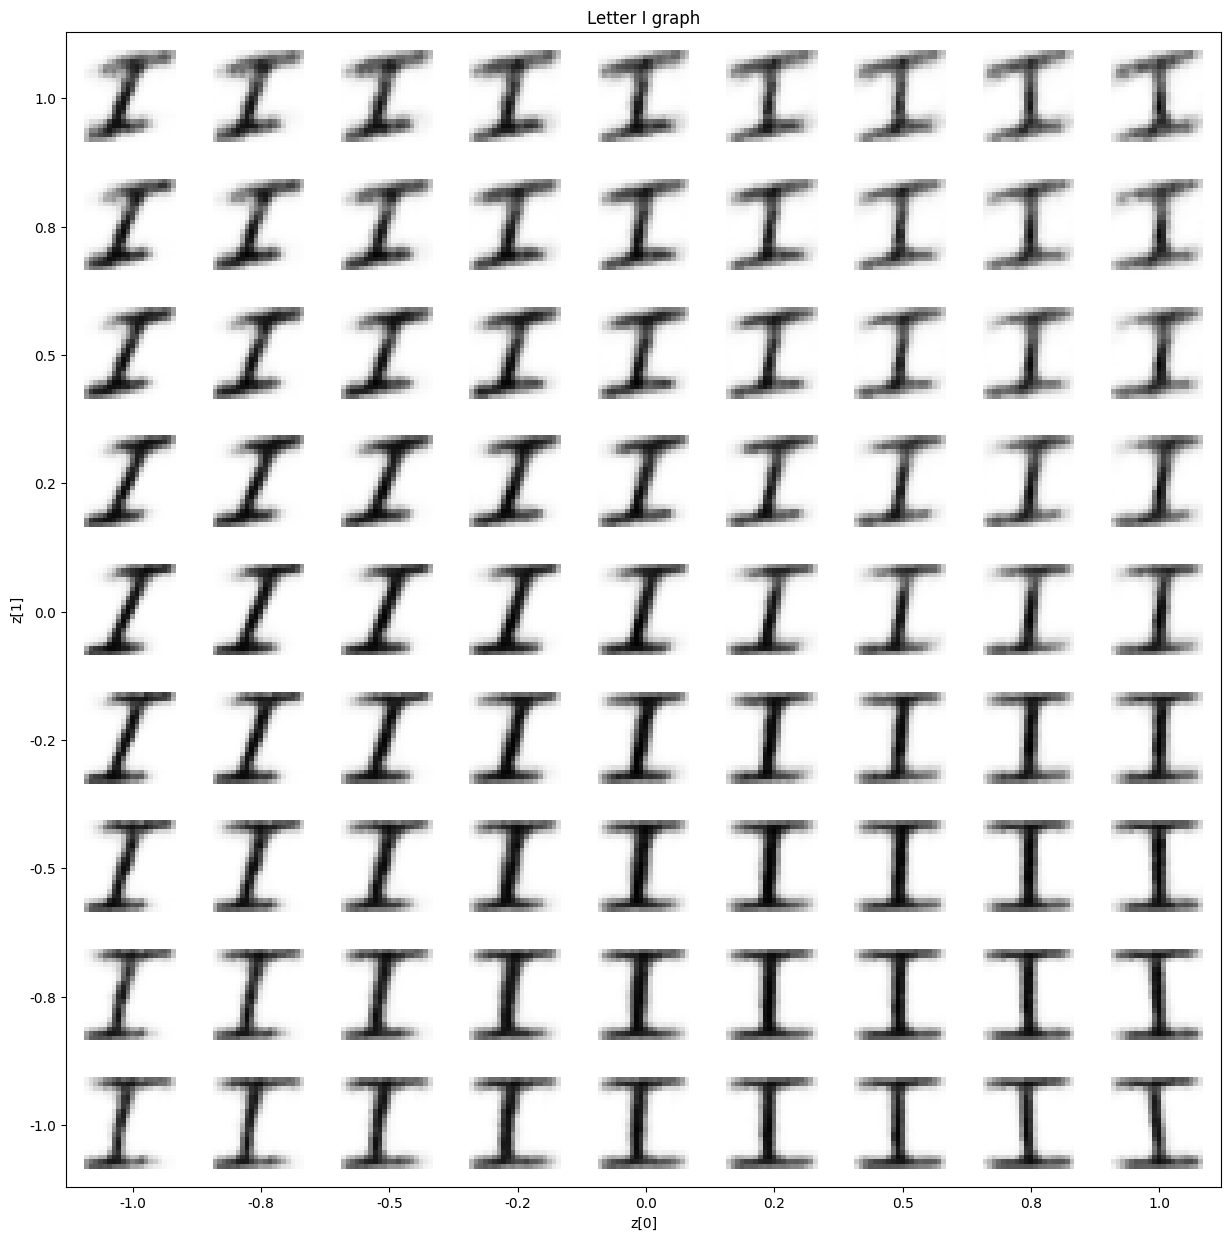

1/1 [==============================] - 0s 26ms/step


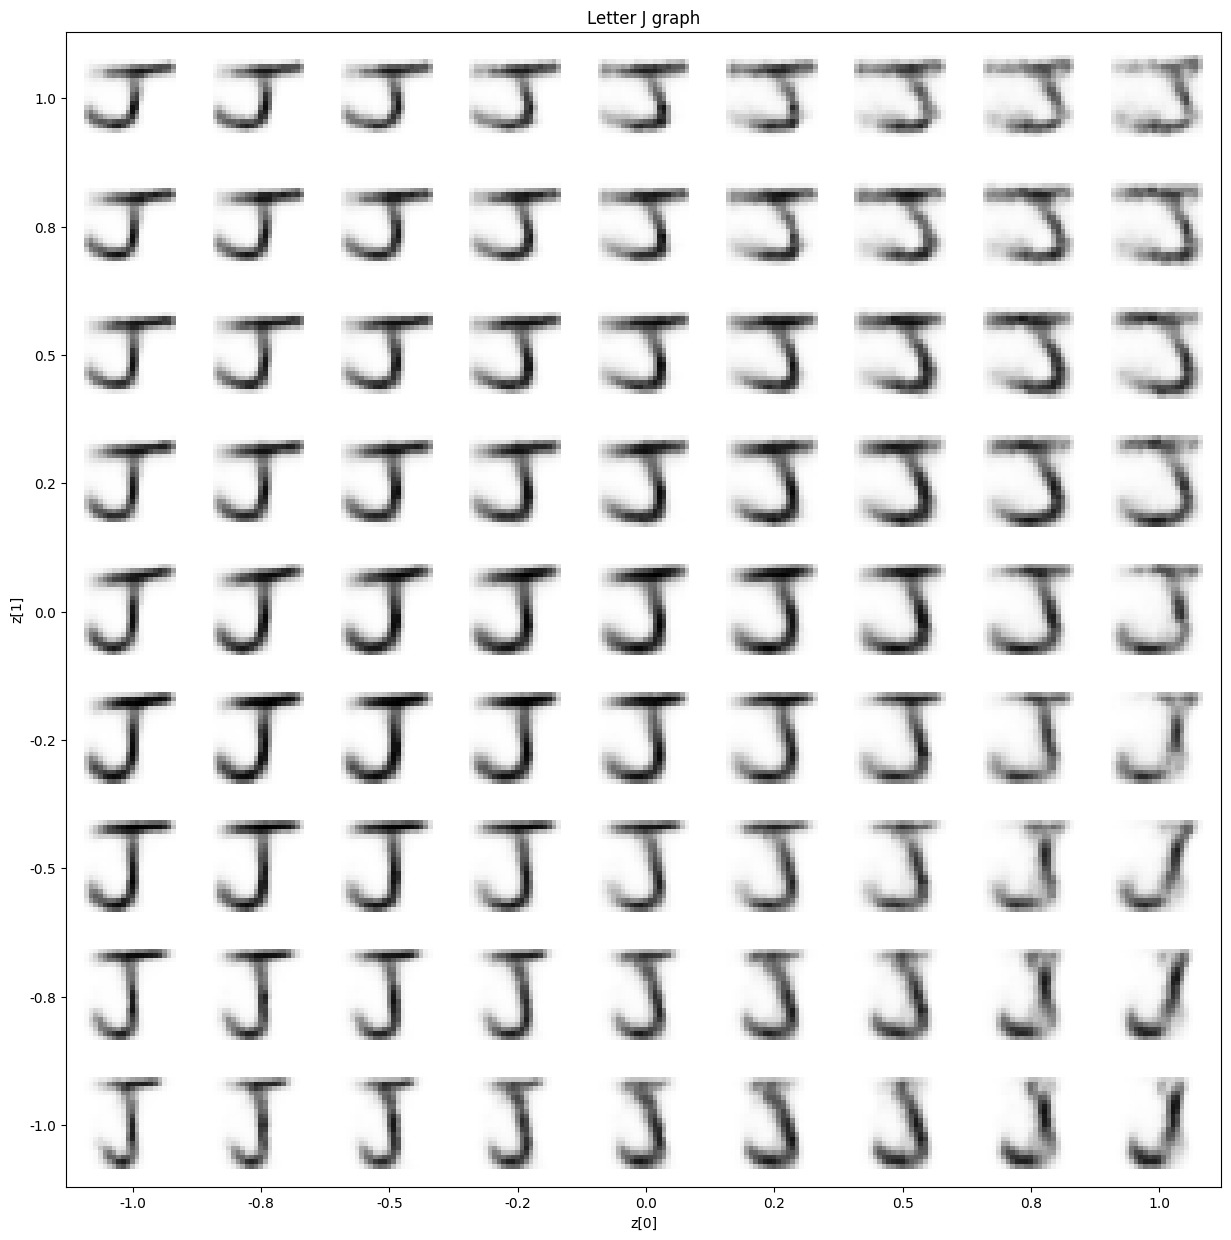

1/1 [==============================] - 0s 17ms/step


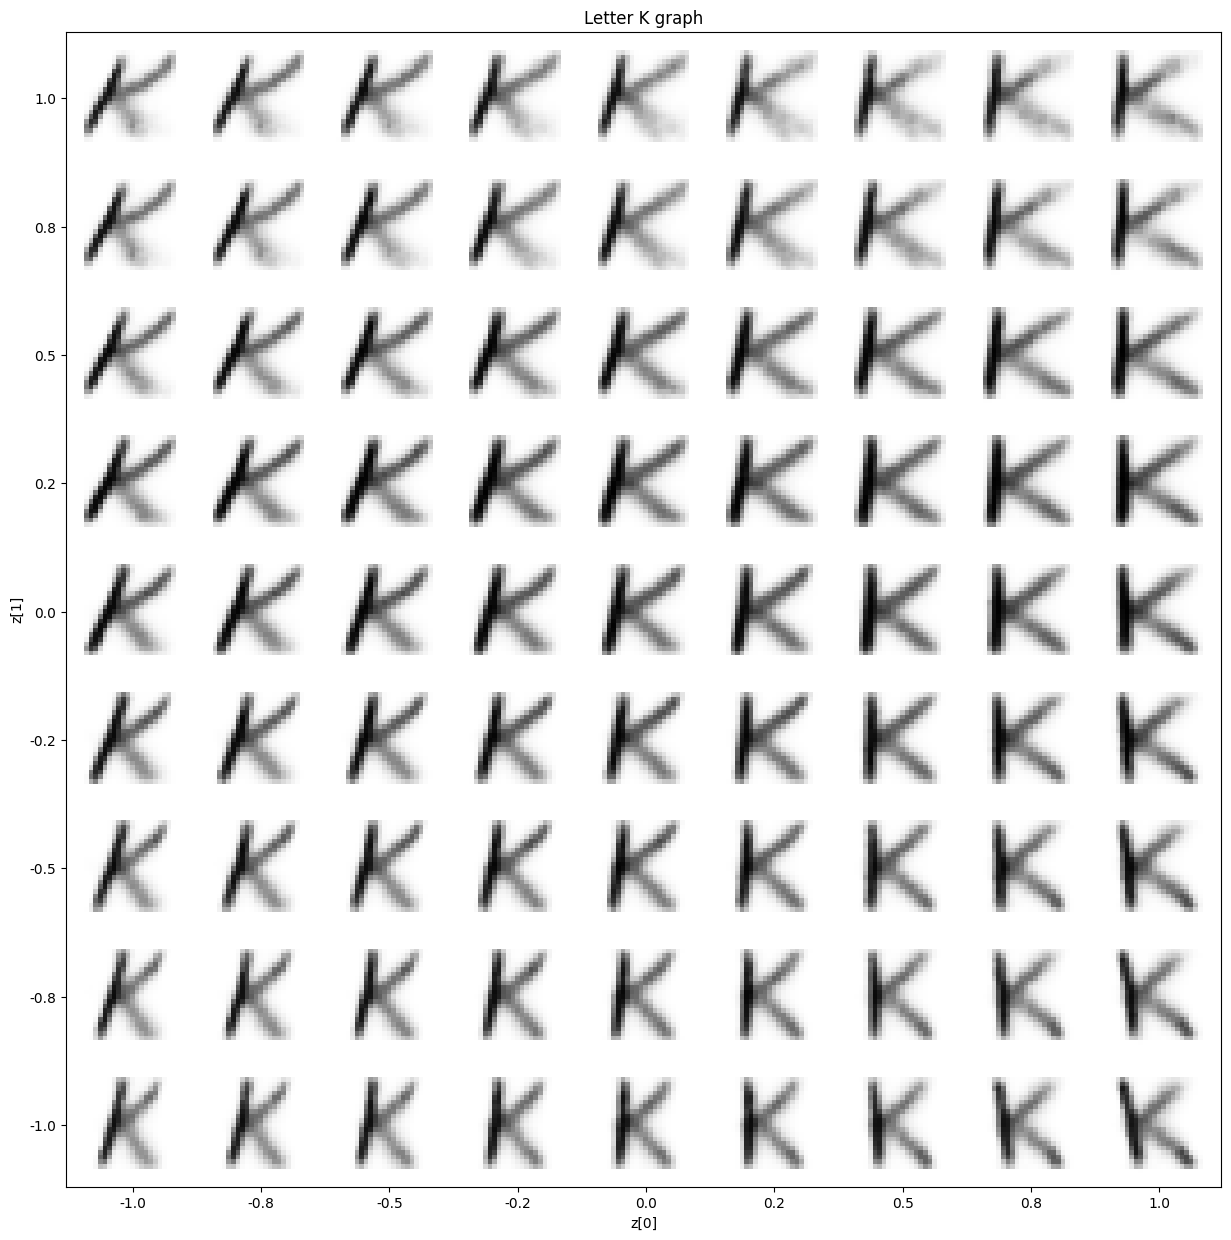

1/1 [==============================] - 0s 25ms/step


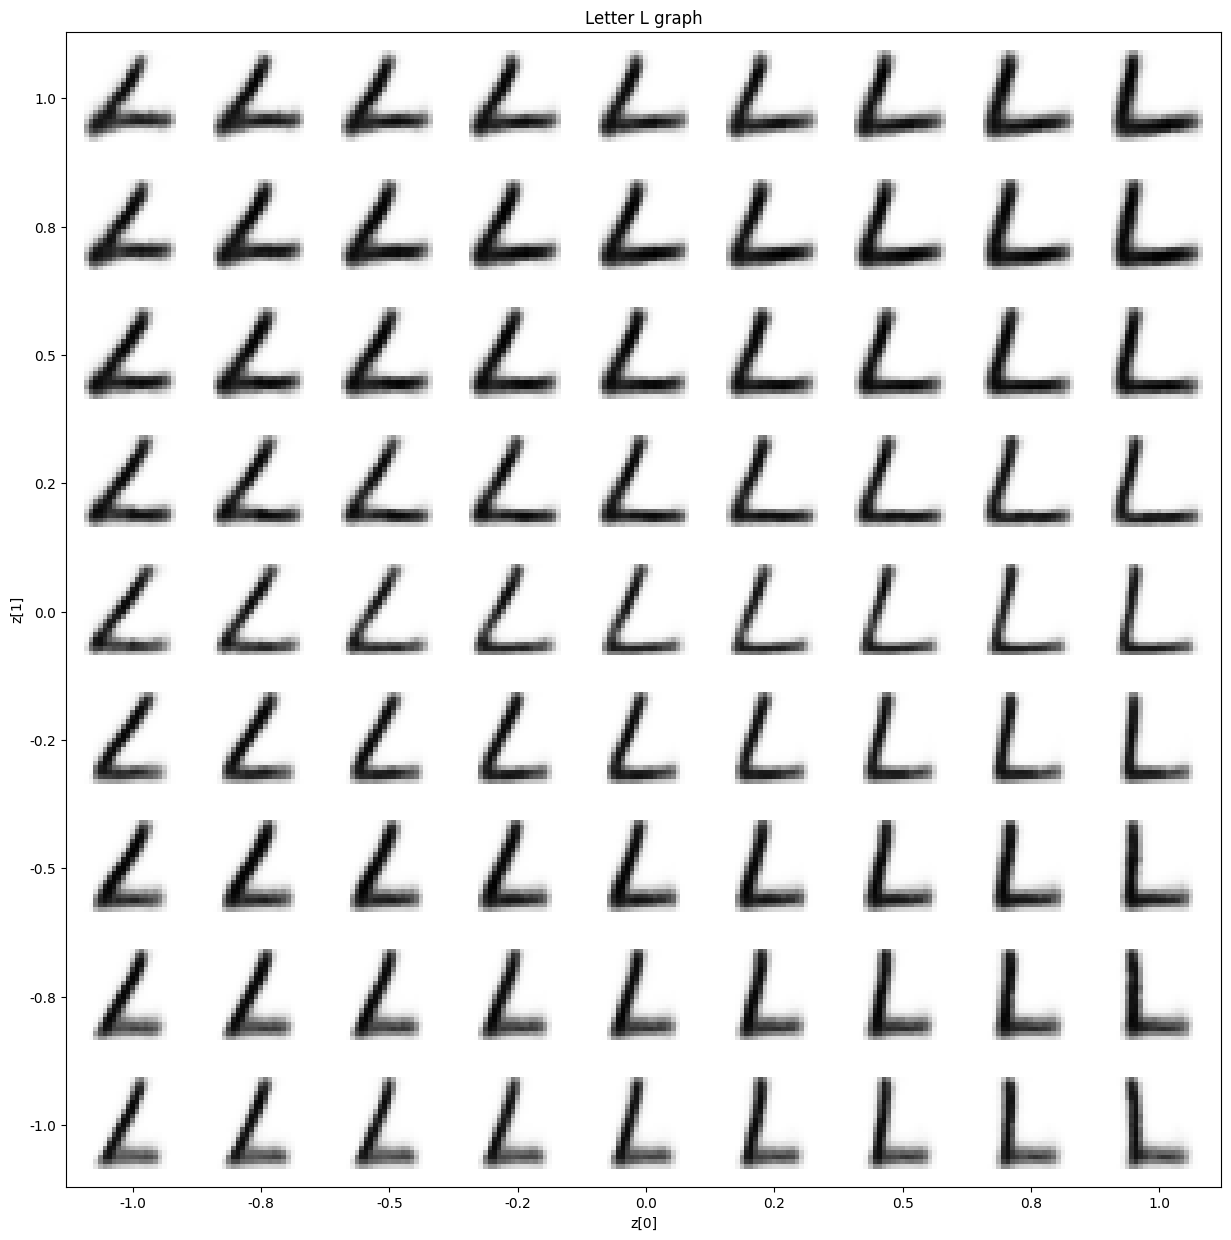

1/1 [==============================] - 0s 27ms/step


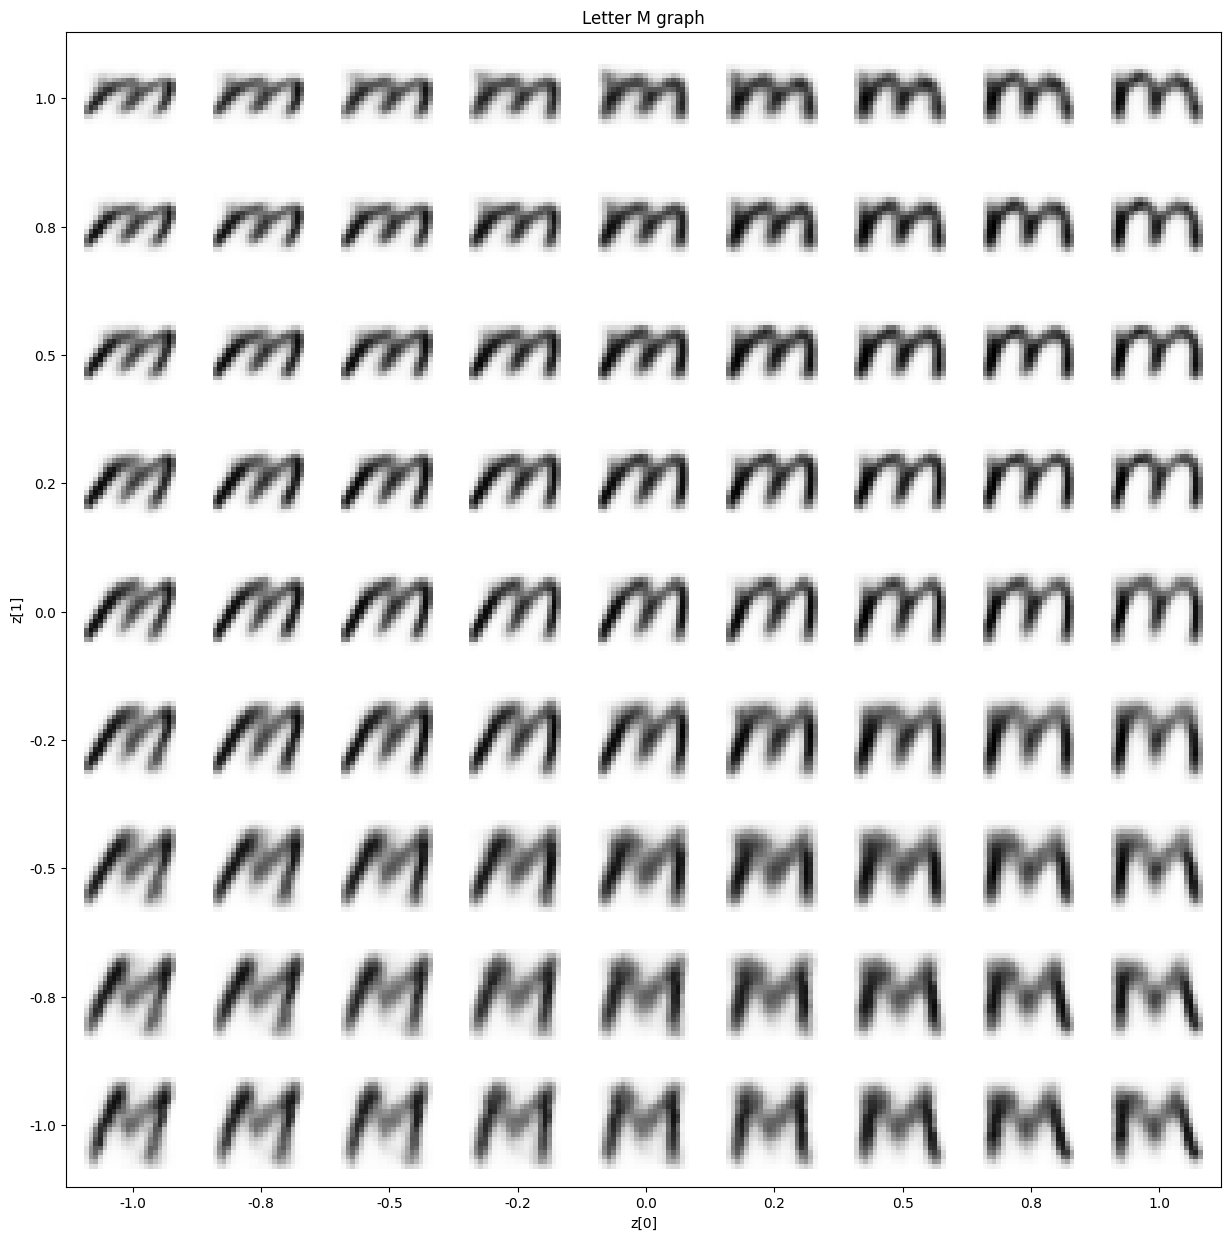

1/1 [==============================] - 0s 16ms/step


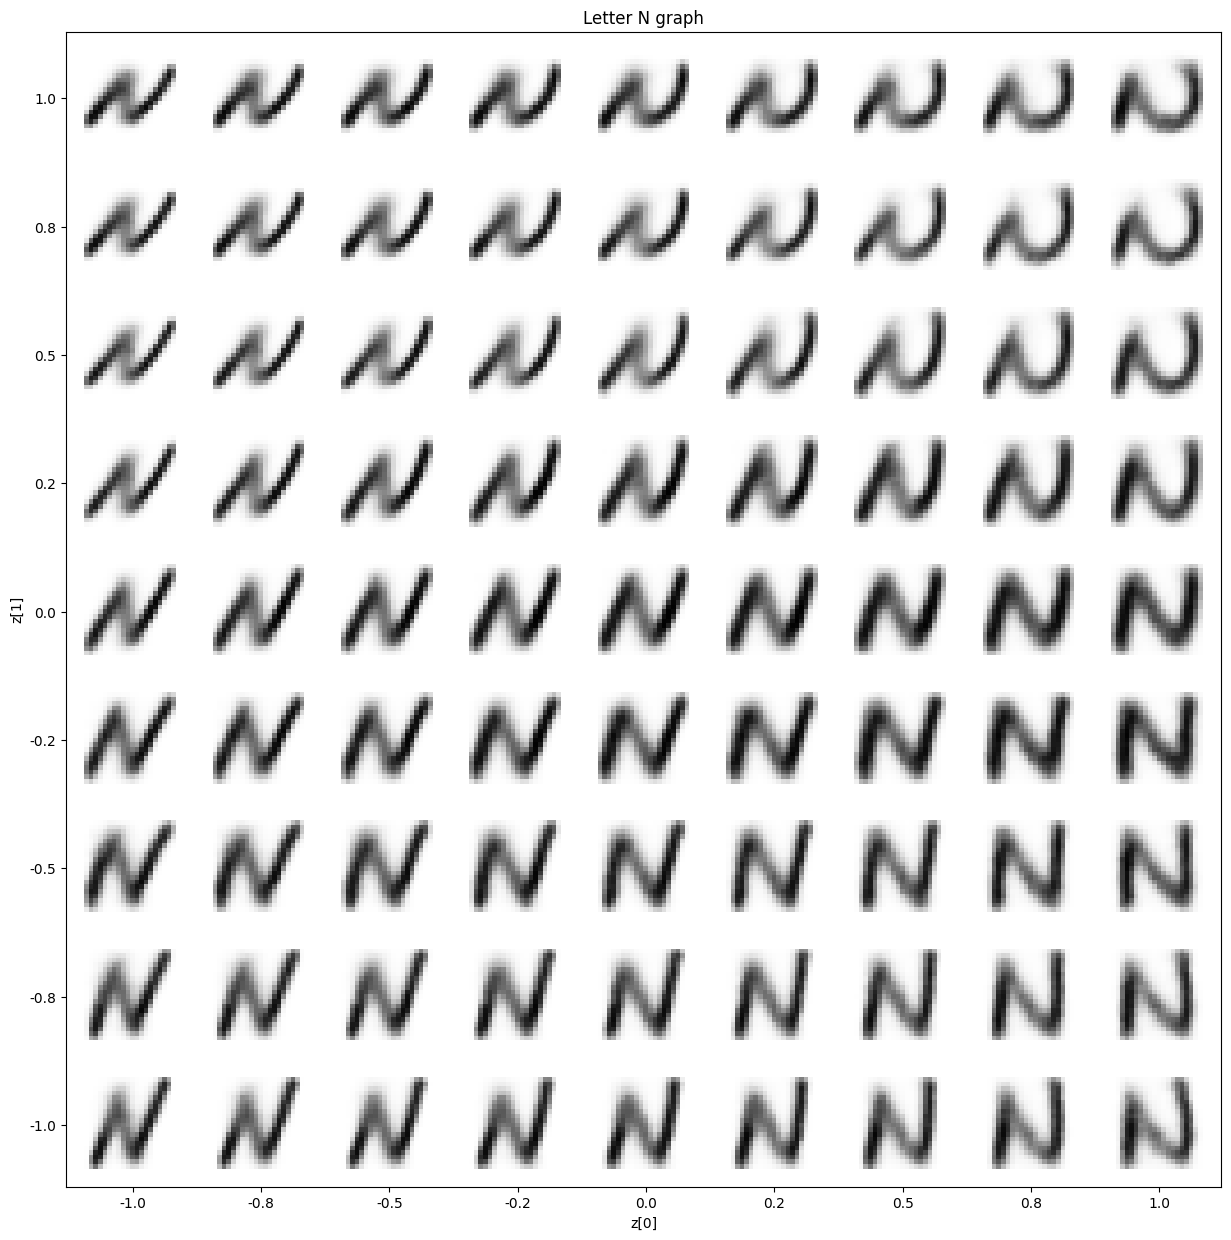

1/1 [==============================] - 0s 26ms/step


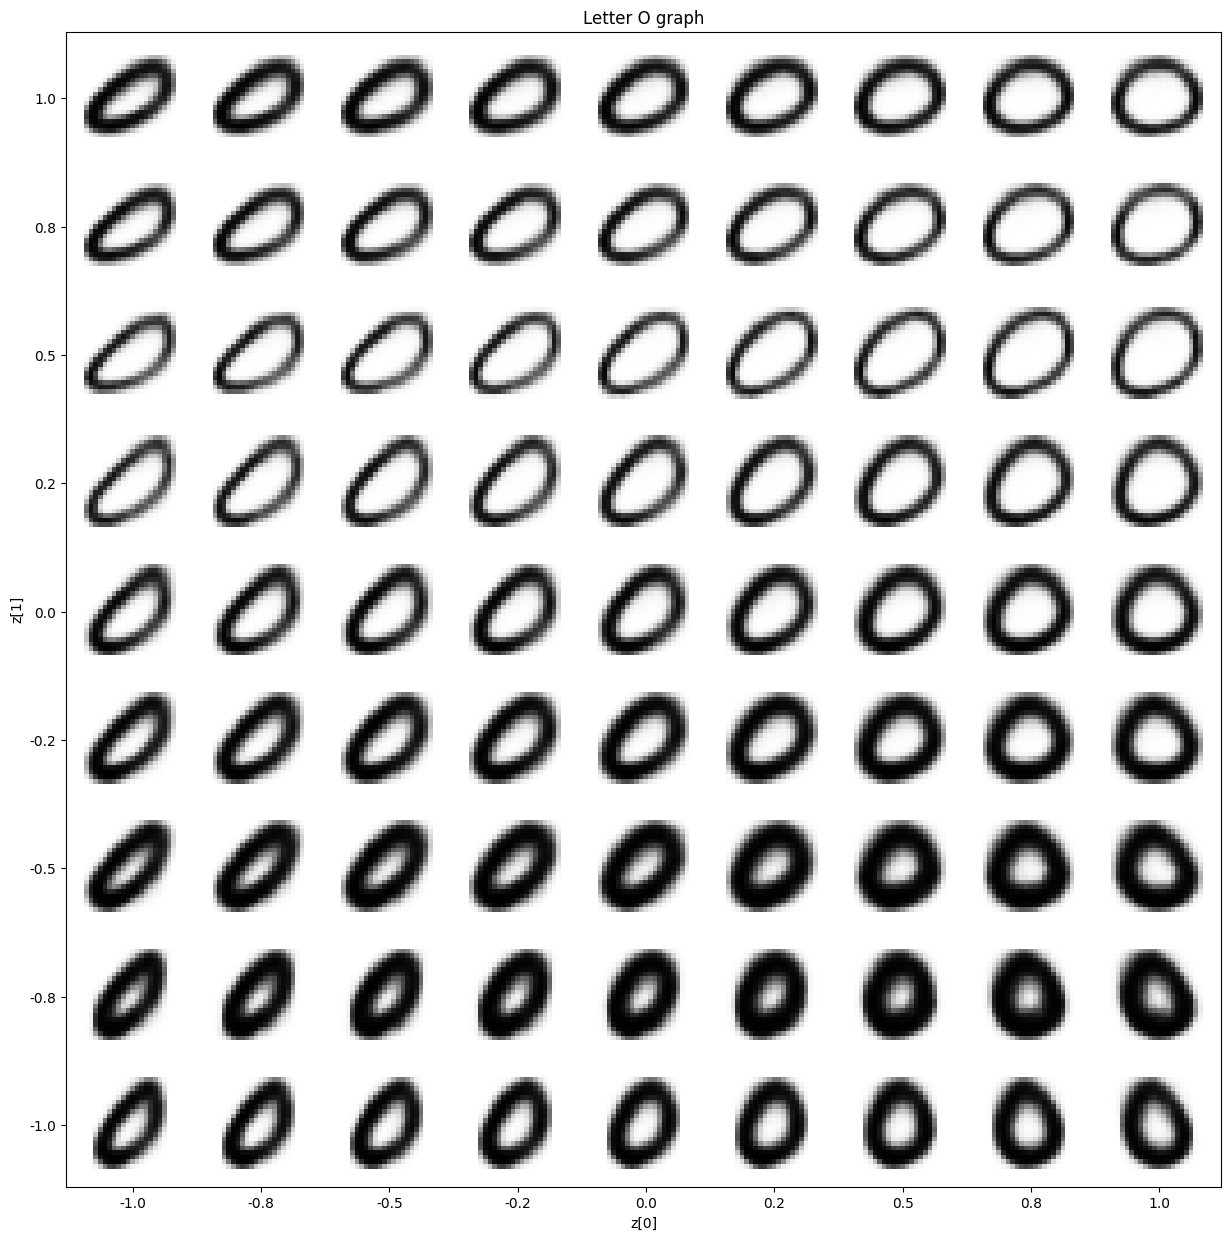

1/1 [==============================] - 0s 17ms/step


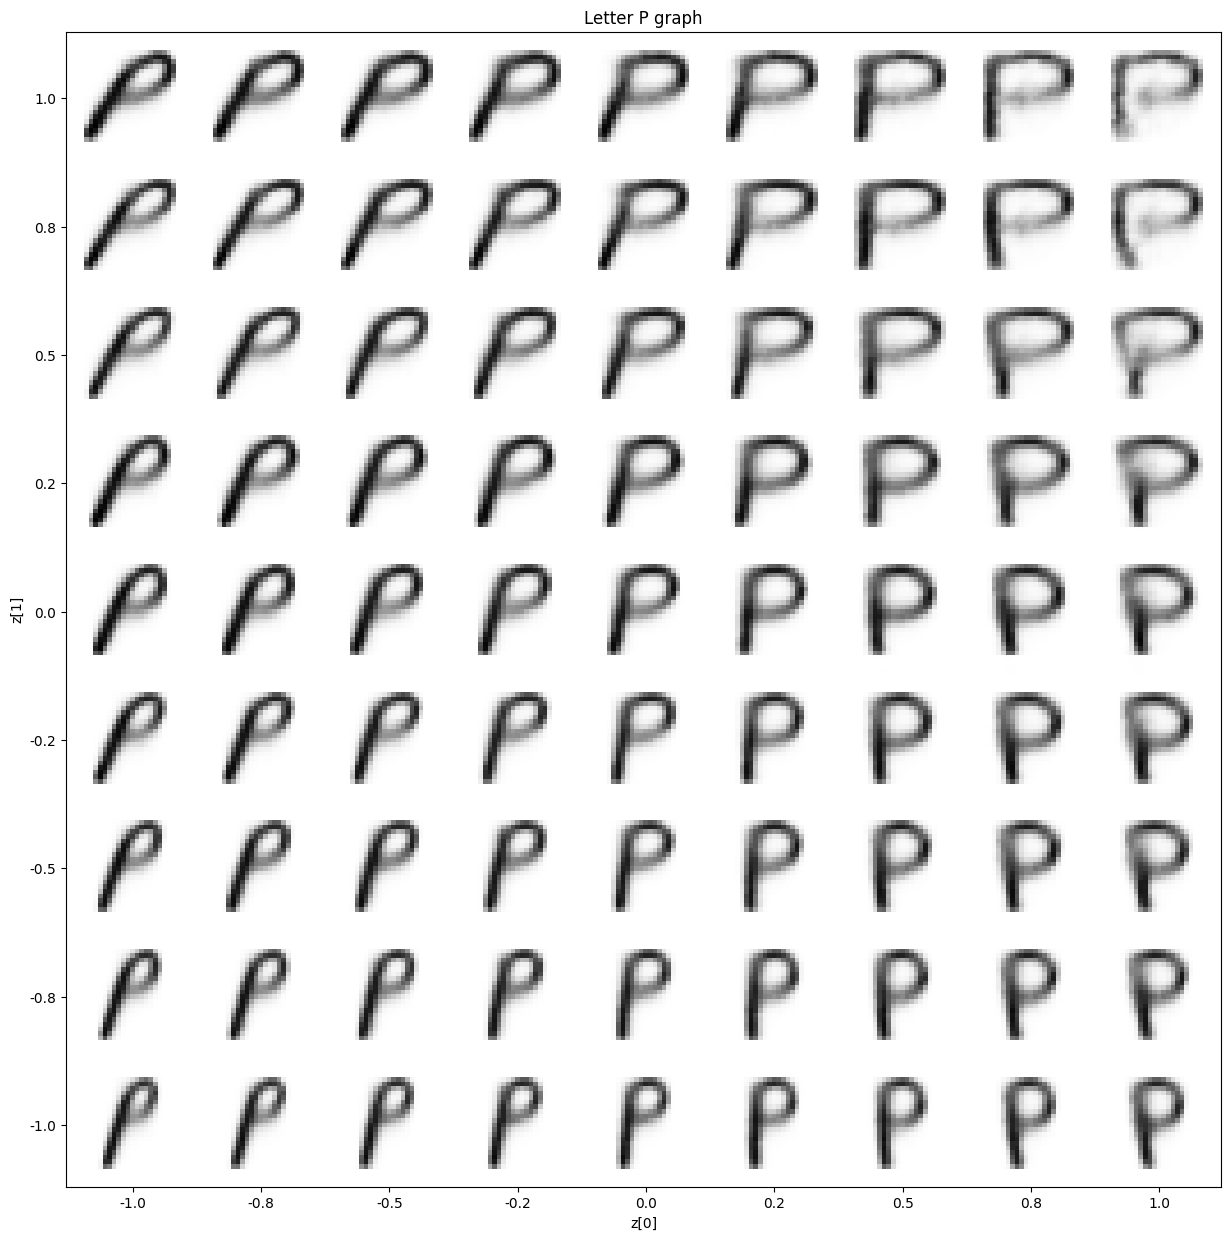

1/1 [==============================] - 0s 16ms/step


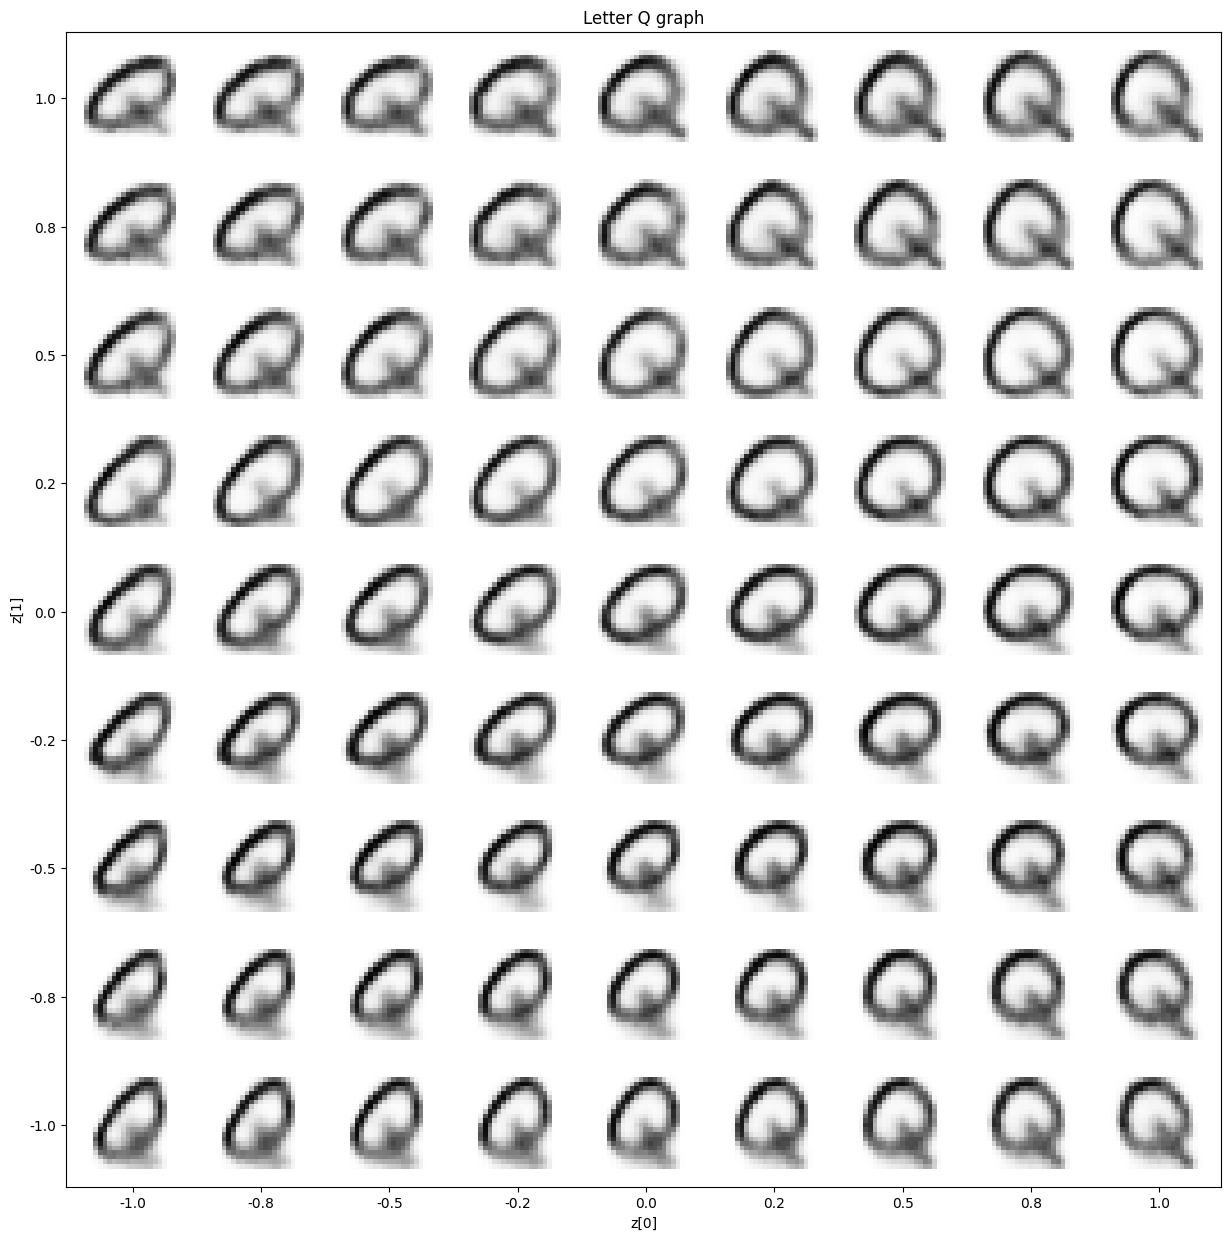

1/1 [==============================] - 0s 27ms/step


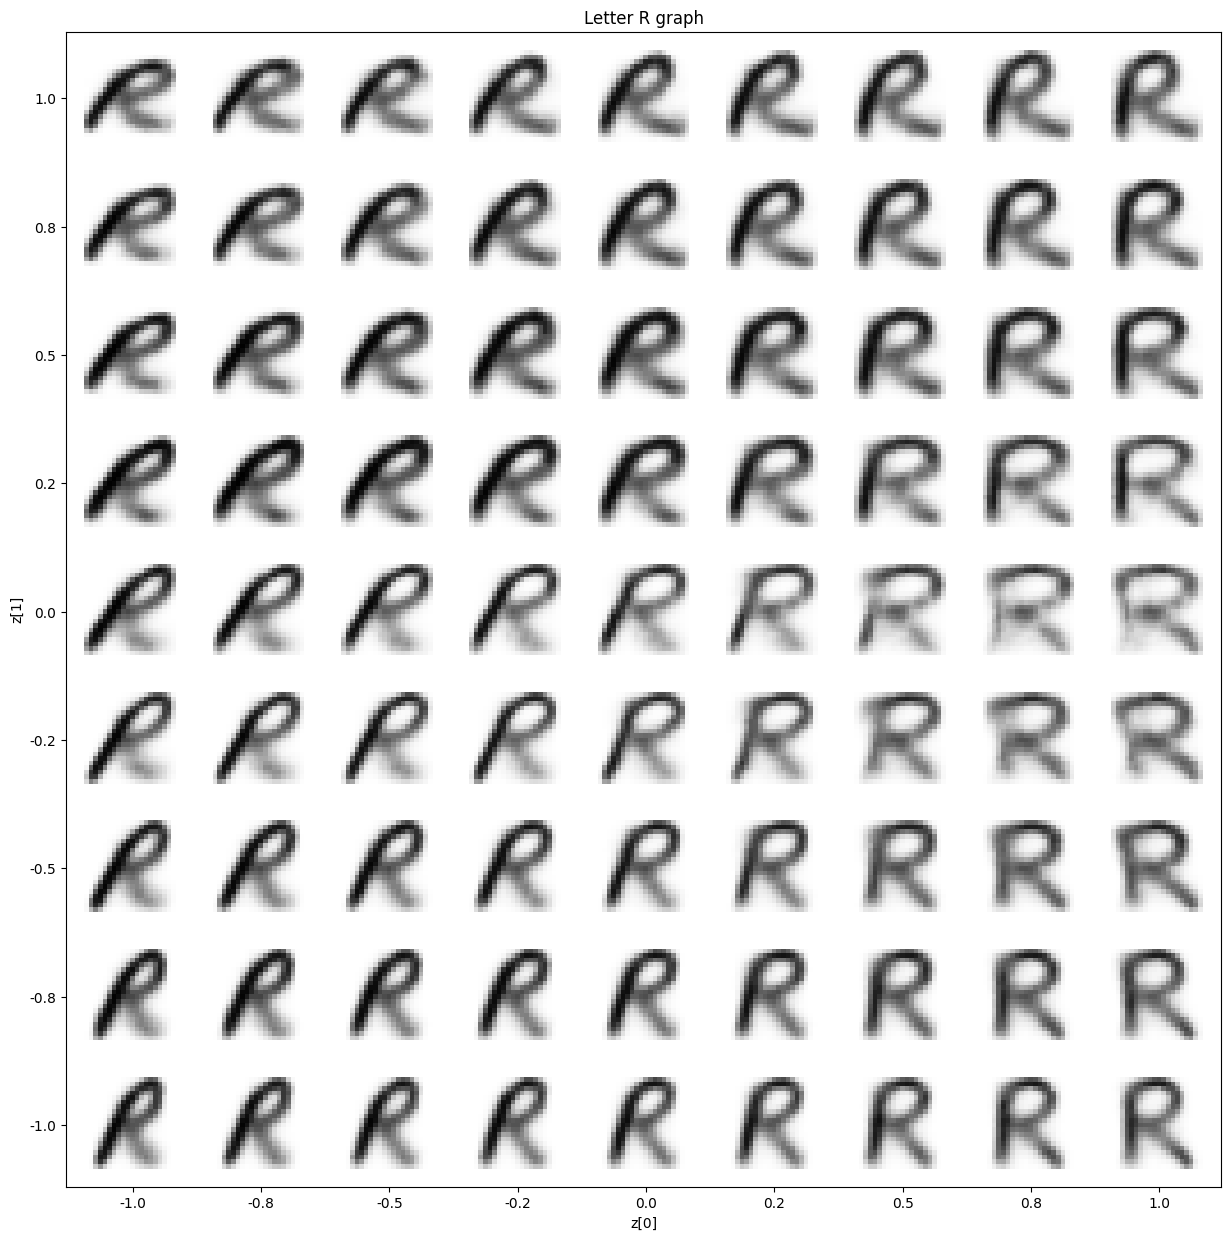

1/1 [==============================] - 0s 16ms/step


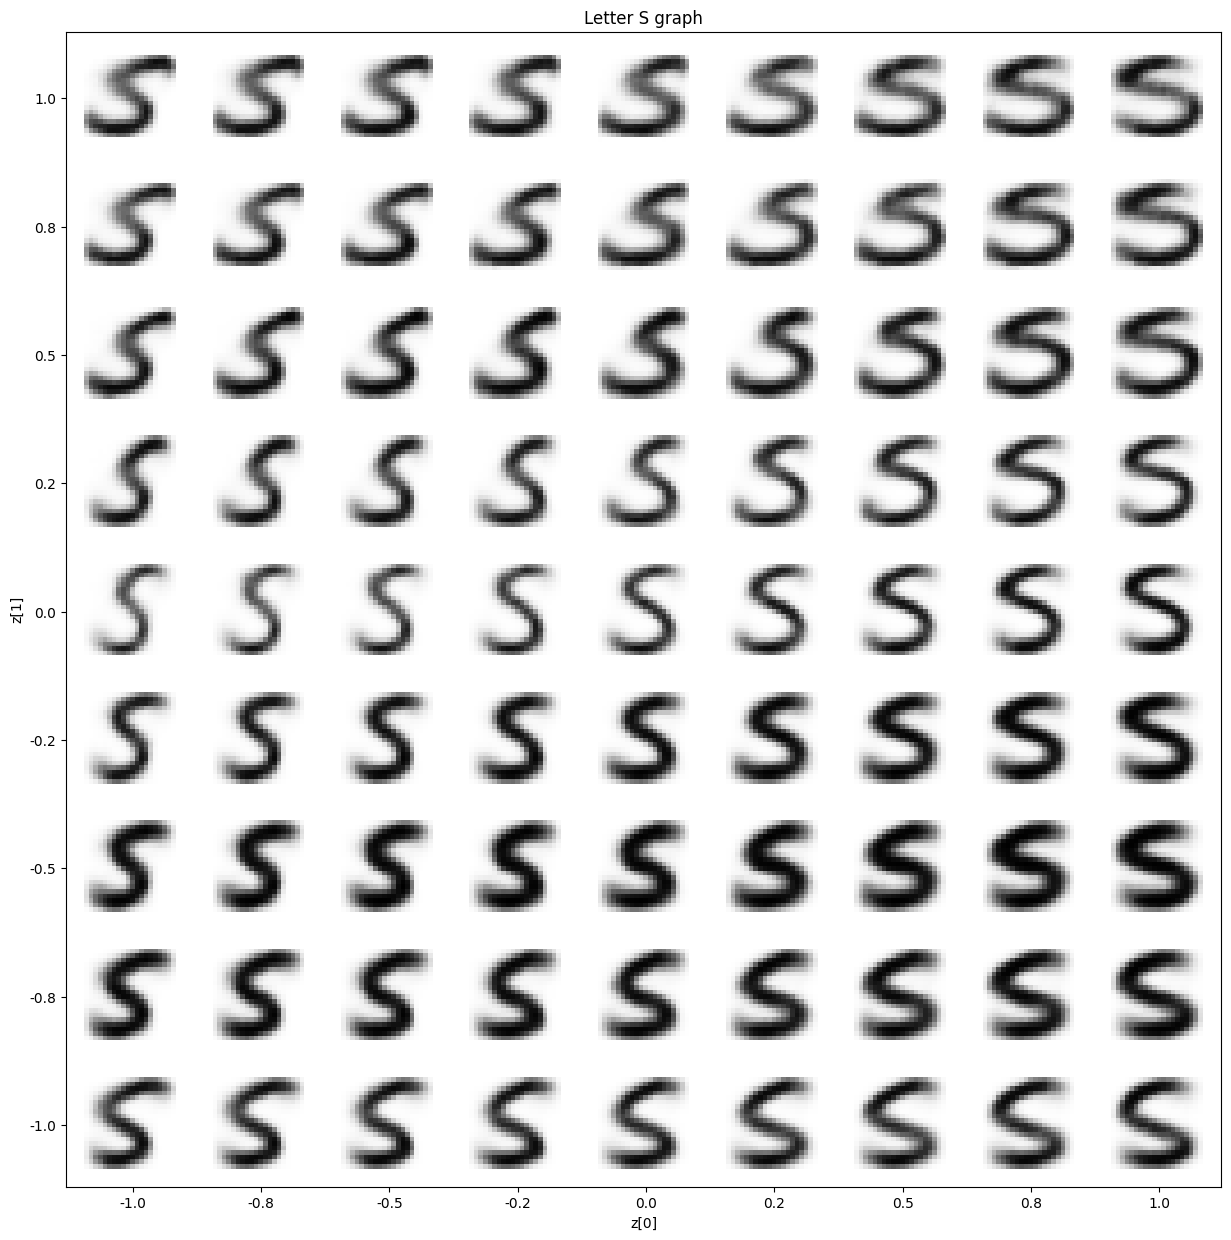

1/1 [==============================] - 0s 17ms/step


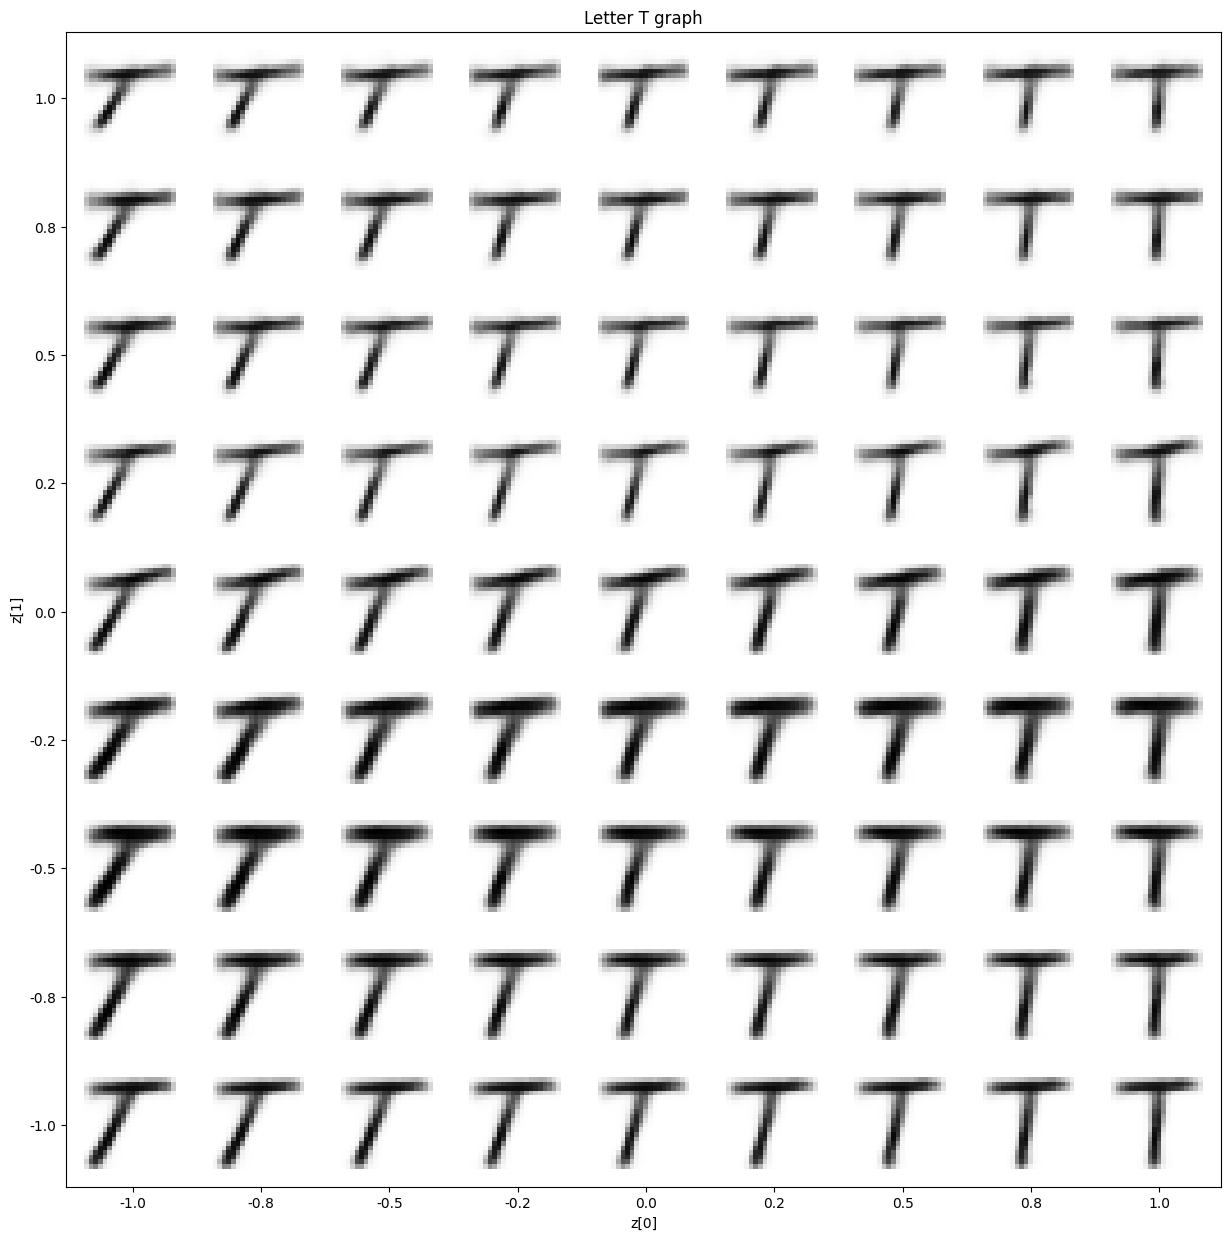

1/1 [==============================] - 0s 18ms/step


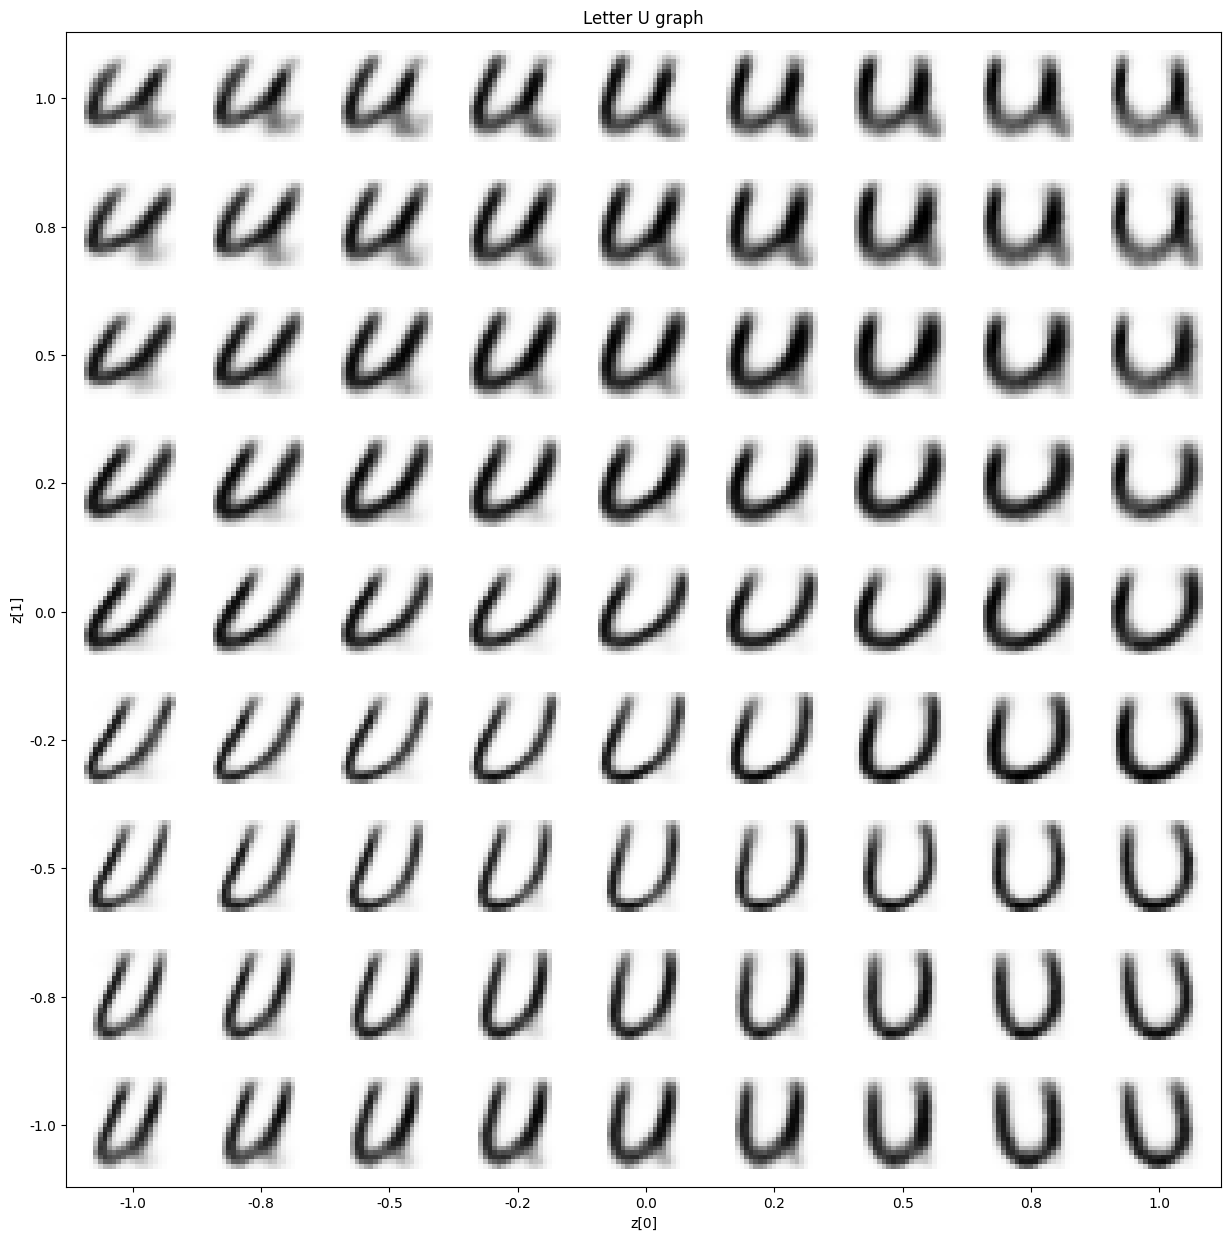

1/1 [==============================] - 0s 16ms/step


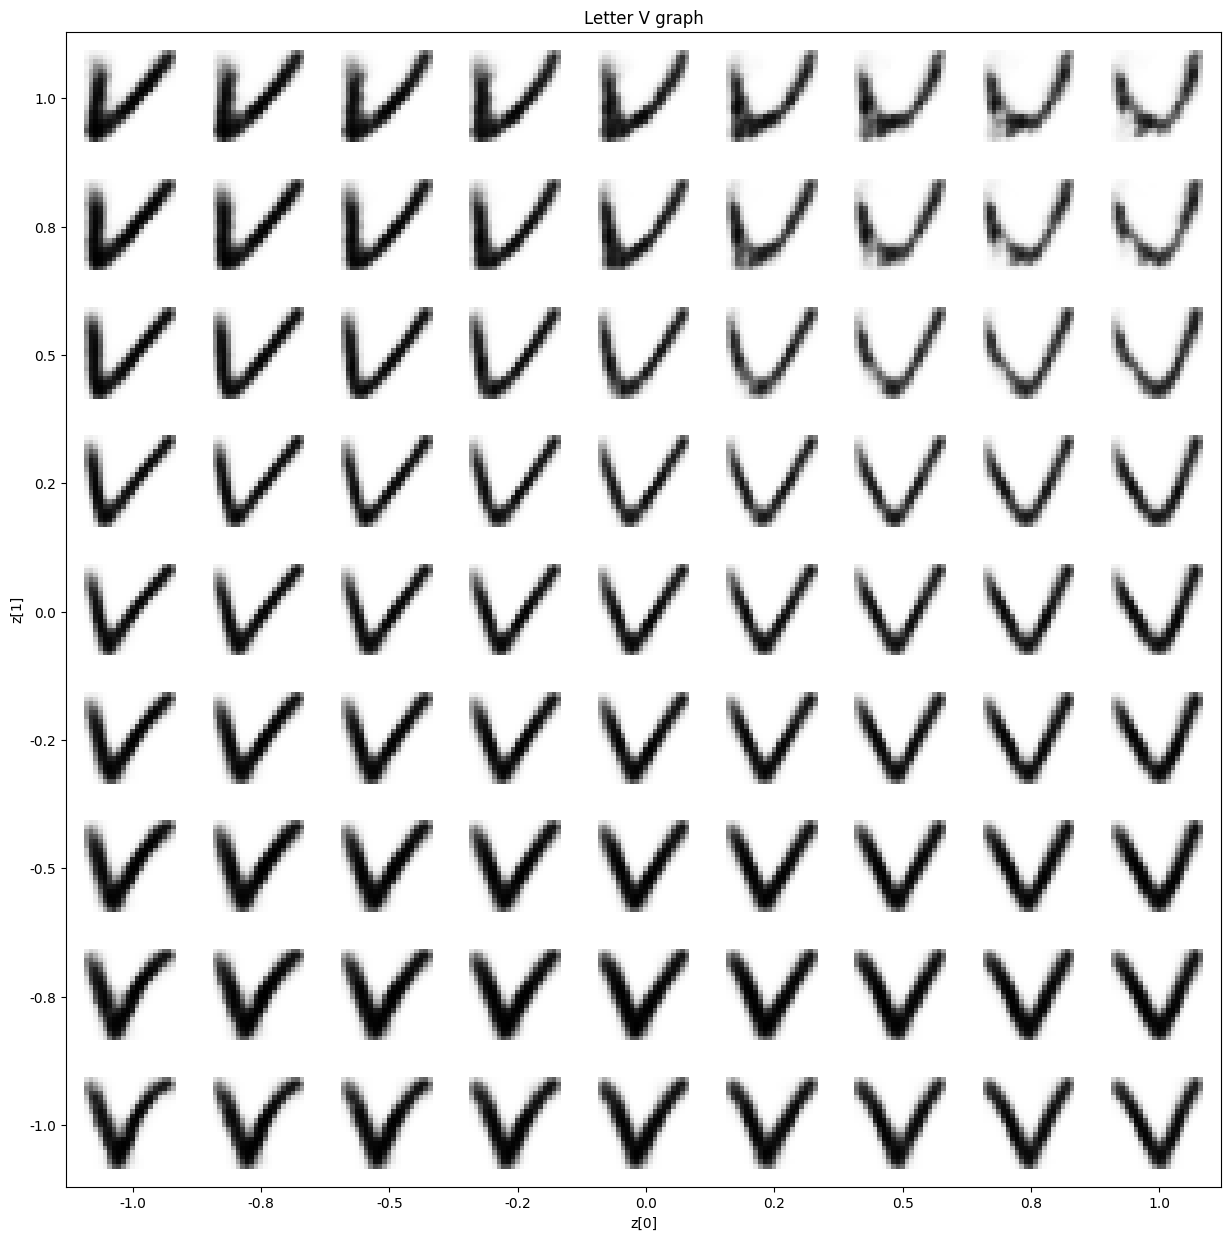

1/1 [==============================] - 0s 26ms/step


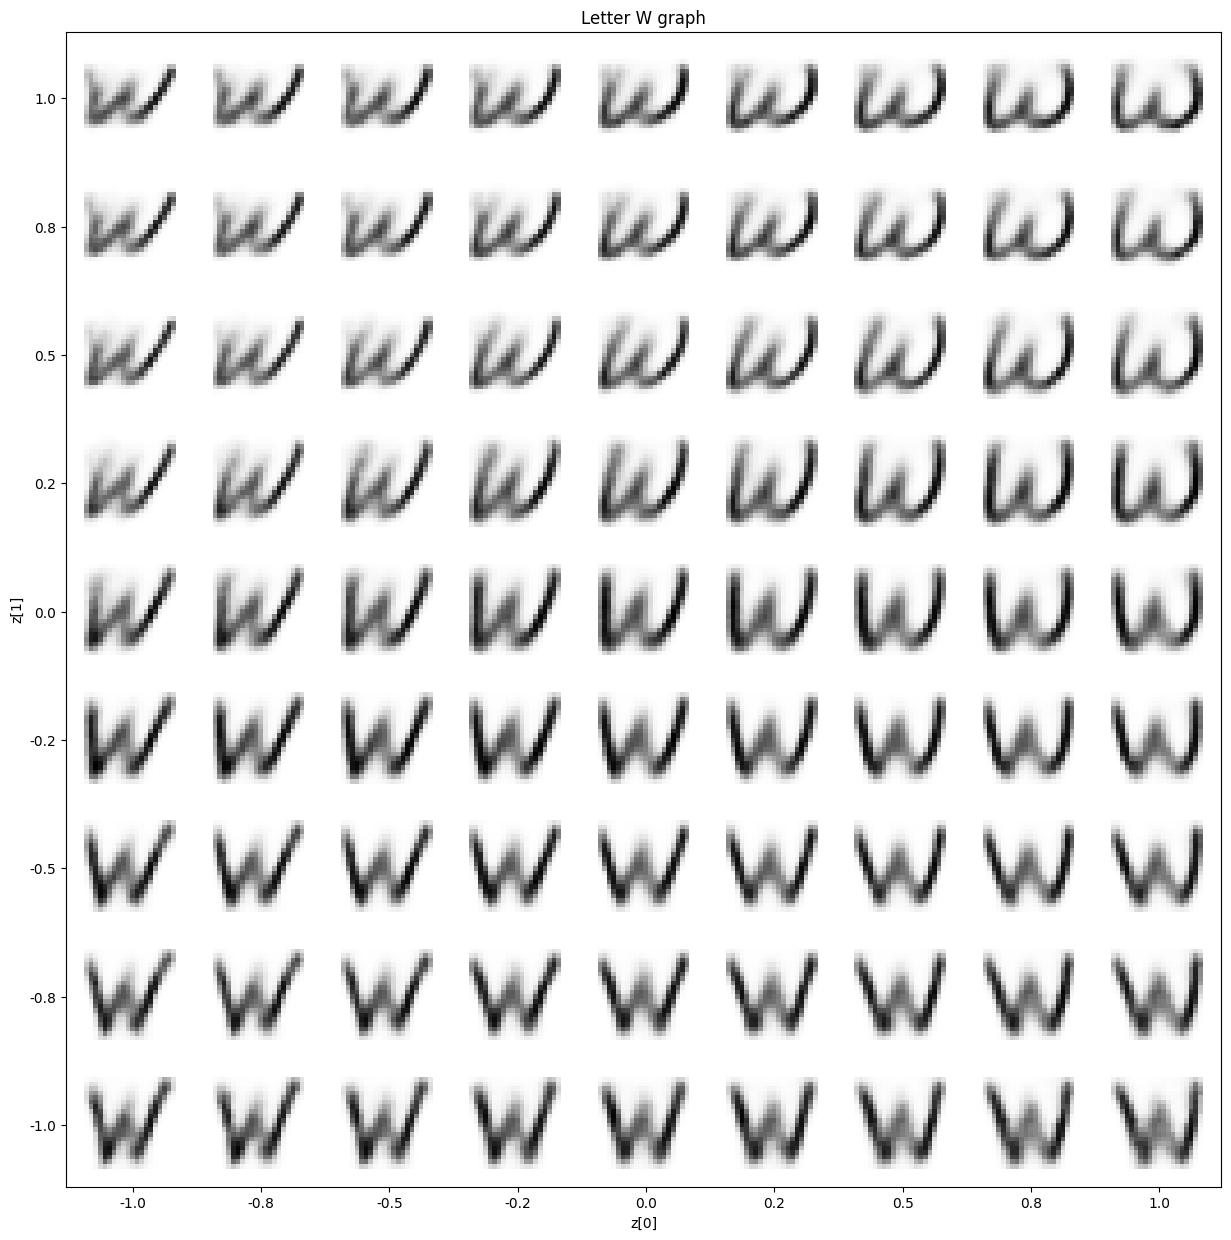

1/1 [==============================] - 0s 22ms/step


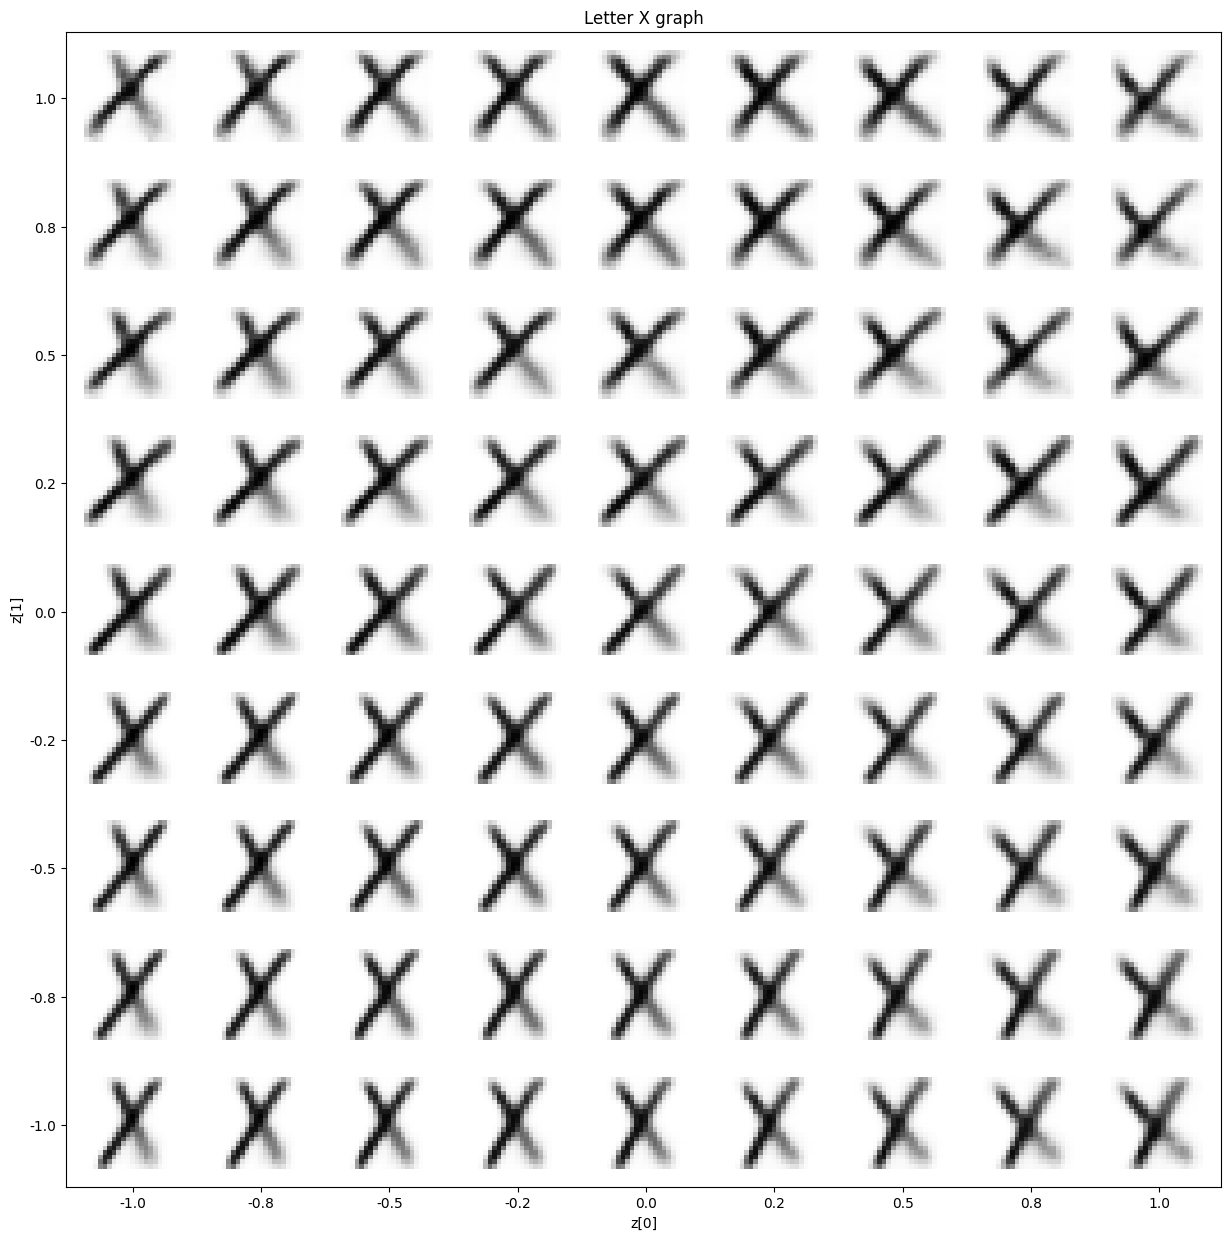

1/1 [==============================] - 0s 16ms/step


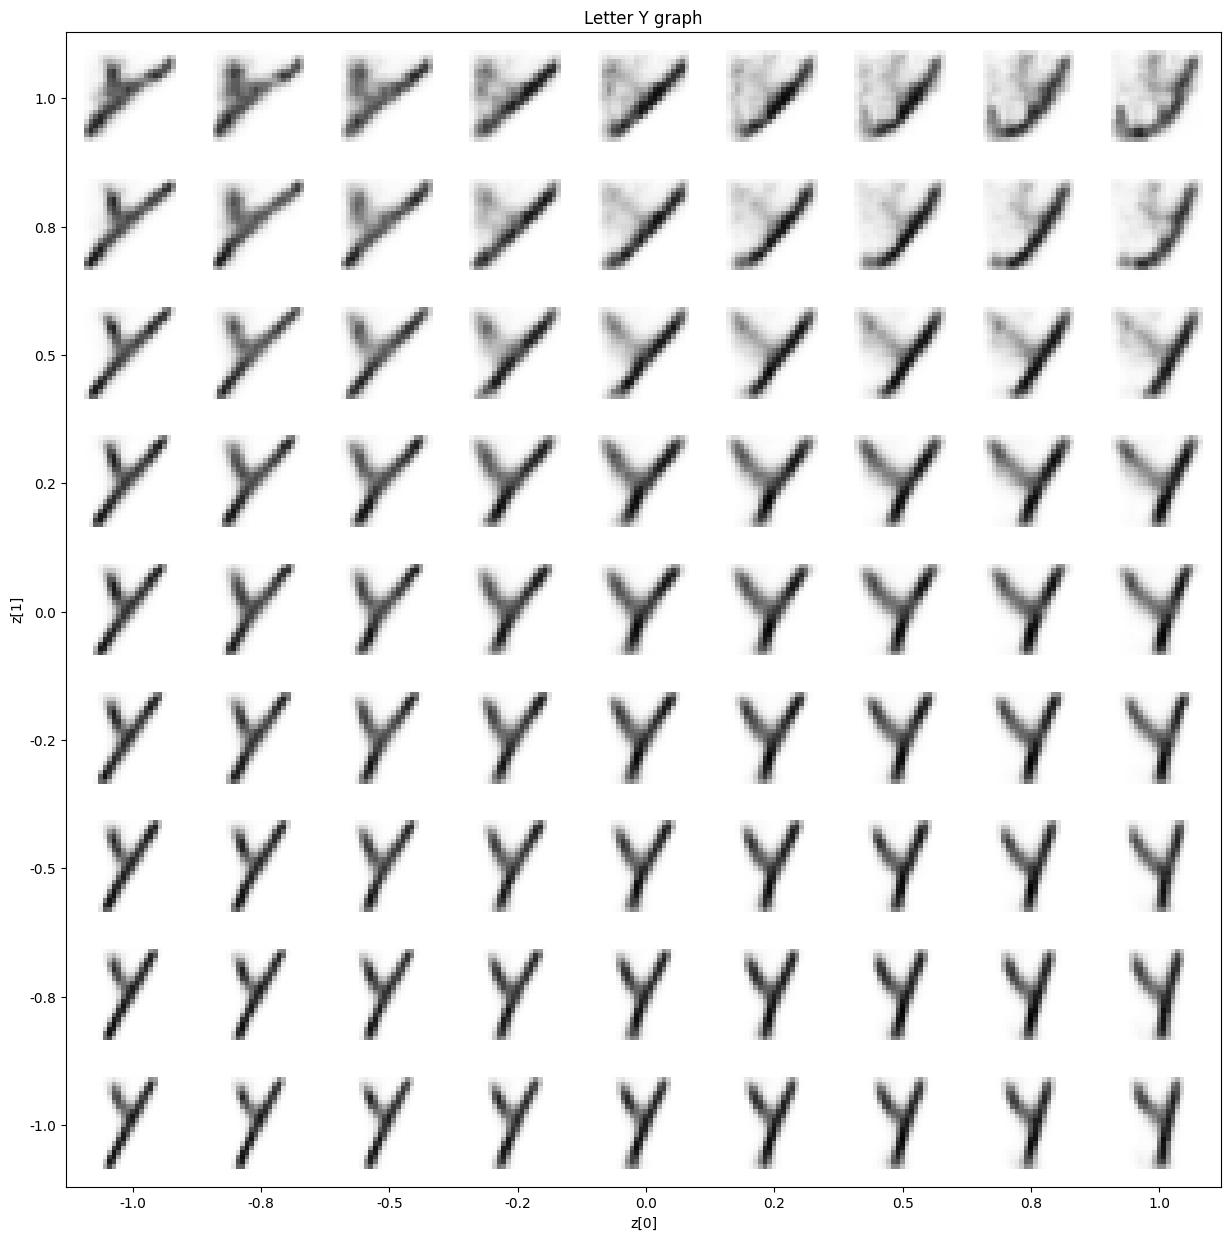

1/1 [==============================] - 0s 17ms/step


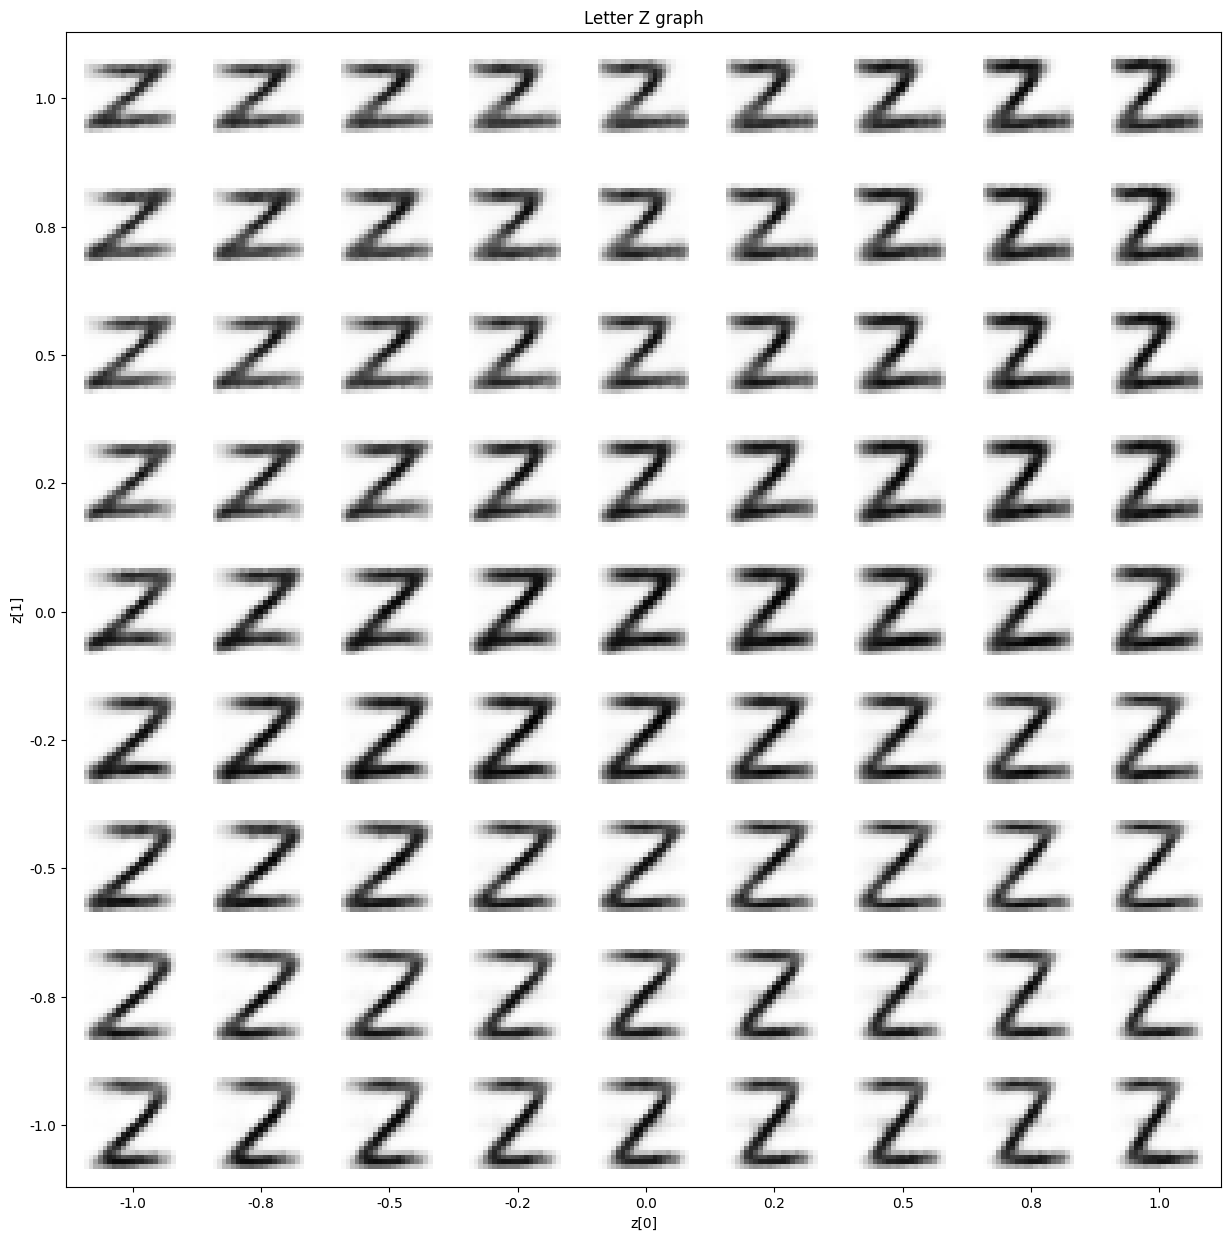

In [56]:
def plot_latent_space(vae, letter_index, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 1))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    letter_index=np.reshape(letter_index, (1, 26))
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([xi, yi])
            z_sample = np.reshape(z_sample, (1,2))
            x_decoded = vae.decoder.predict([z_sample, letter_index])
            digit = x_decoded[0].reshape(digit_size, digit_size, 1)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f"Letter {dictionary.get(np.argmax(letter_index))} graph")
    plt.imshow(figure, cmap="Greys")
    plt.show()



    
ohe_index = to_categorical(np.arange(0,26))
for i in ohe_index:
    plot_latent_space(vae, i, n=9)